# **Hyperparameter tuning**

In [325]:
import re
import os
import sys
import warnings; warnings.filterwarnings('ignore')

import pandas as pd

utils_path = os.path.join(os.getcwd(), '..', '..', '..')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

from notebooks.src.utils import plots, constants

## **Constants**

In [326]:
TUNING_FOLDER = constants.TUNING_FOLDER
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER

TUNING_RAW_FOLDER = os.path.join(TUNING_FOLDER, 'raw')
TUNING_CLEANED_FOLDER = os.path.join(TUNING_FOLDER, 'cleaned')

LVL1_RESULTS = os.path.join(TUNING_RAW_FOLDER, 'lvl1_without_sentencepiece.csv')
LVL2_RESULTS = os.path.join(TUNING_RAW_FOLDER, 'lvl2.csv')
LVL3_TRANSFORMER_GN_ES_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                              'lvl3_transformer_gn_es.csv')
LVL3_TRANSFORMER_ES_GN_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                              'lvl3_transformer_es_gn.csv')
LVL3_S2S_GN_ES_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                      'lvl3_s2s_gn_es.csv')
LVL3_S2S_ES_GN_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                      'lvl3_s2s_es_gn.csv')

BEST_MODELS_CSV = os.path.join(TUNING_CLEANED_FOLDER, 
                               'best_models.csv')

FINAL_DOCUMENT_PATH = os.path.join(RESULTS_FOLDER,
                                   'final_document')

FIGSIZE_LEVEL1 = (16, 5)

## **Auxiliar functions**

In [327]:
CHRF_VALUE = 'chrF'
BLEU_VALUE = 'BLEU'
SCORE_VALUE = 'Desempeño'
MODEL_NAME_VALUE = 'Modelo'

def prettify_model_name(model_name: str, level: int, significative_figures=2):
    if level == 1:
        if 'transformer' in model_name:
            return 'Transformer'

        if 's2s' in model_name:
            return 'Seq2Seq'
        
    elif level == 2:
        enc_depth_regex = r'enc-depth_(\d+)'
        enc_depth = re.findall(enc_depth_regex, model_name)

        if enc_depth:
            enc_depth = enc_depth[0]
            return f'depth_{enc_depth}'
        
        max_length = re.findall(r'max-length_(\d+)', model_name)
        if max_length:
            max_length = max_length[0]
            return f'max_length_{max_length}'
        
        label_smoothing = re.findall(r'label-smoothing_(\d+\.\d+)', model_name)
        if label_smoothing:
            label_smoothing = label_smoothing[0]
            return f'label_smoothing_{label_smoothing}'
        
        enc_cell = re.findall(r'enc-cell_(\w+)', model_name)
        if enc_cell:
            enc_cell = enc_cell[0]
            return f'enc_cell_{enc_cell}'
        
        dim_vocabs = re.findall(r'V(\d+)', model_name)
        if dim_vocabs:
            dim_vocabs = dim_vocabs[0]
            return f'dim_vocabs_{dim_vocabs}'
        
        if 'default' in model_name:
            return 'default'
        
    elif level == 3:        
        learn_rate = re.findall(r'learn-rate_(\d+\.\d+)', model_name)
        learn_rate = learn_rate[0] if learn_rate else 'default'
        
        lr_cientific_notation = re.findall(r'(\d+\.\d+)(e-\d+)', model_name)
        if lr_cientific_notation:
            lr_cientific_notation = lr_cientific_notation[0]
            learn_rate = (lr_cientific_notation[0][:significative_figures+2] + 
                         lr_cientific_notation[1])
        else:
            lr_significative_figures = re.findall(r'(\d+\.[0]*)(\d+)', learn_rate)
            if lr_significative_figures:
                lr_significative_figures = lr_significative_figures[0]
                learn_rate = lr_significative_figures[0] + lr_significative_figures[1][:significative_figures]
        
        max_length = re.findall(r'max-length_(\d+)', model_name)
        max_length = max_length[0] if max_length else 'default'

        enc_depth = re.findall(r'enc-depth_(\d+)', model_name)
        enc_depth = enc_depth[0] if enc_depth else 'default'

        dim_vocabs = re.findall(r'dim-vocabs_(\d+)', model_name)
        dim_vocabs = dim_vocabs[0] if dim_vocabs else 'default'
        len_dim_vocabs = len(dim_vocabs)
        dim_vocabs = dim_vocabs[:len_dim_vocabs//2]

        model_name = f'lr_{learn_rate}_maxlen_{max_length}_depth_{enc_depth}_dimvocabs_{dim_vocabs}'

    return model_name

def df_prettier(df: pd.DataFrame, level=1):
    score_type_mapping = {'sacrebleu_corpus_chrf': CHRF_VALUE,
                        'sacrebleu_corpus_bleu': BLEU_VALUE}
    column_rename_mapping = {'score': SCORE_VALUE,
                            'model_name': MODEL_NAME_VALUE}

    df = df.copy()
    df['score_type'] = df['score_type'].map(score_type_mapping)
    df = df.rename(columns=column_rename_mapping)

    df[MODEL_NAME_VALUE] = df[MODEL_NAME_VALUE].apply(lambda x: prettify_model_name(x, level))
    return df

## **Level 1**

Here we tested the default hyperparameters to have a baseline for our tuned models.

In [328]:
lvl1_df = pd.read_csv(LVL1_RESULTS)
lvl1_df.tail()

date                  model_name           source  \
191  2023-07-26 14:06:16.307205  es_gn_lvl1_transformer.npz  valid_es.txt.es   
192  2023-07-26 14:07:36.626009  es_gn_lvl1_transformer.npz  valid_es.txt.es   
193  2023-07-26 14:07:36.626009  es_gn_lvl1_transformer.npz  valid_es.txt.es   
194  2023-07-26 14:08:53.427986  es_gn_lvl1_transformer.npz  valid_es.txt.es   
195  2023-07-26 14:08:53.427986  es_gn_lvl1_transformer.npz  valid_es.txt.es   

              target             score_type      score  epoch  \
191  valid_gn.txt.gn  sacrebleu_corpus_bleu   2.738466      7   
192  valid_gn.txt.gn  sacrebleu_corpus_chrf  17.213538      8   
193  valid_gn.txt.gn  sacrebleu_corpus_bleu   2.614965      8   
194  valid_gn.txt.gn  sacrebleu_corpus_chrf  18.309891      9   
195  valid_gn.txt.gn  sacrebleu_corpus_bleu   2.817177      9   

                                            parameters  
191  {'devices': ['0', '1'], 'early-stopping': ['7'...  
192  {'devices': ['0', '1'], 'early-stopping': ['7'...  
193  {'devices': ['0', '1'], 'early-stopping': ['7'...  
194  {'devices': ['0', '1'], 'early-stopping': ['7'...  
195  {'devices': ['0', '1'], 'early-stopping': ['7'...

**Visual analysis**

In [329]:
gn_es_results = lvl1_df[lvl1_df['source'].str.contains('gn', regex=False)]
es_gn_results = lvl1_df[lvl1_df['source'].str.contains('es', regex=False)]

### **GN -> ES**

In [330]:
gn_es_results_prettier = df_prettier(gn_es_results)
es_gn_results_prettier = df_prettier(es_gn_results)

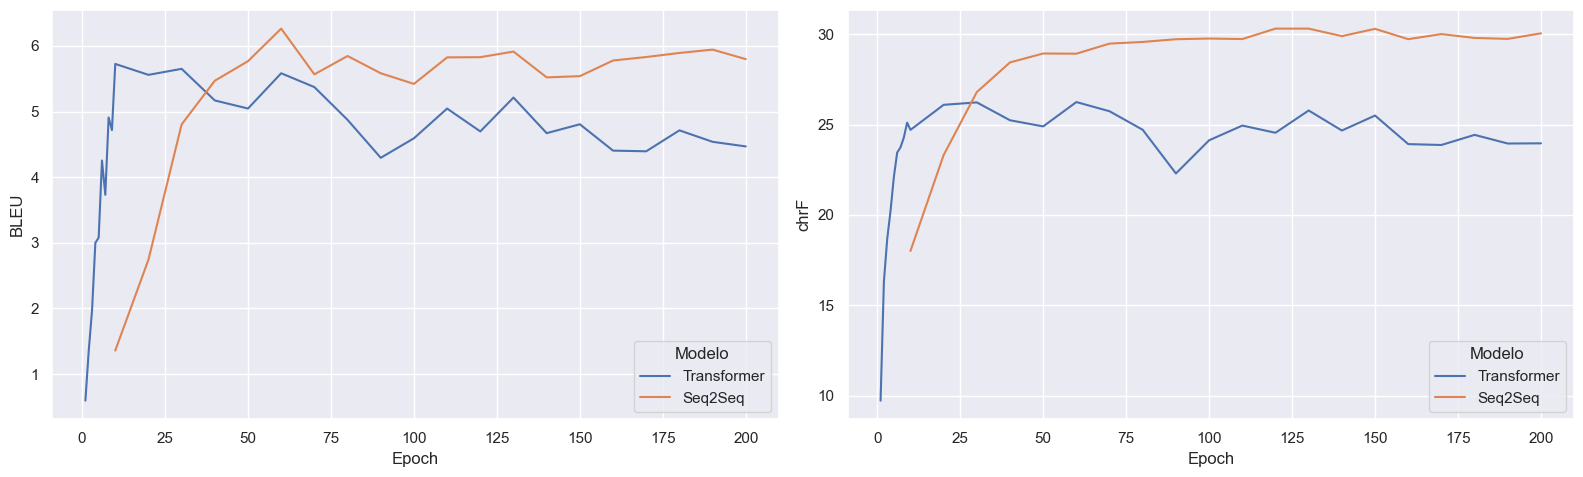

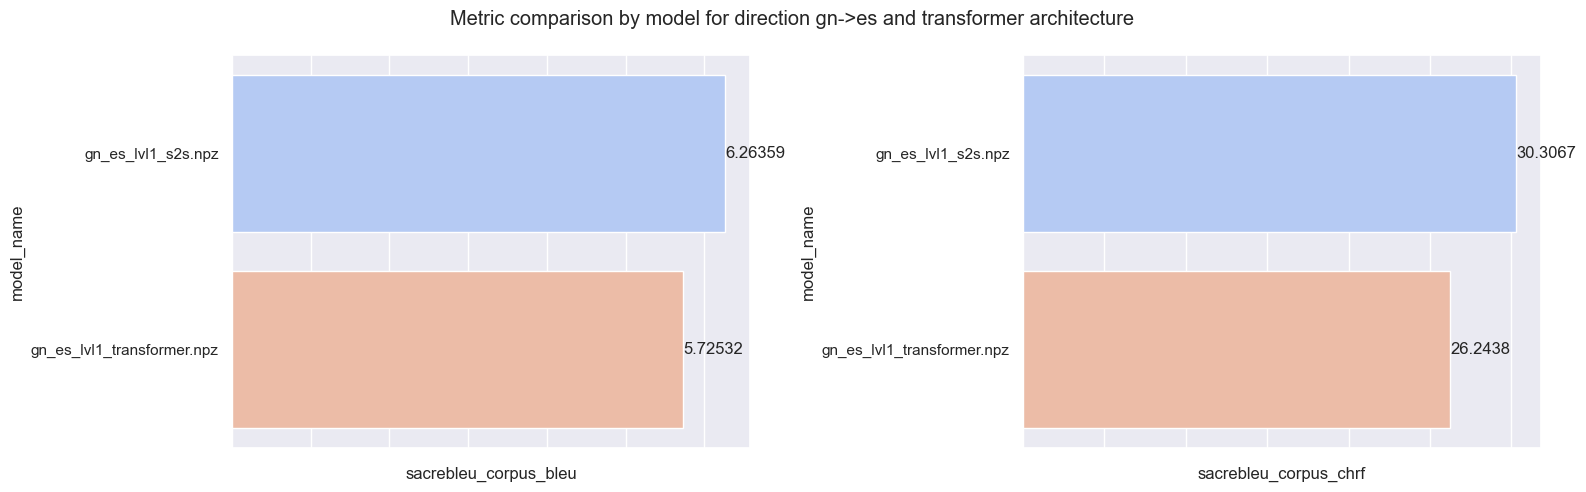

In [331]:
plots.plot_metric_by_epoch_foreach_model(gn_es_results_prettier, 
                                         title='',
                                         metrics=[BLEU_VALUE, CHRF_VALUE],
                                         model_name=MODEL_NAME_VALUE,
                                         score_name=SCORE_VALUE,

                                         save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                                'level1_gn_es_results.png'),
                                         figsize=FIGSIZE_LEVEL1);

plots.plot_max_score_by_model(gn_es_results,
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=FIGSIZE_LEVEL1);

### **ES -> GN**

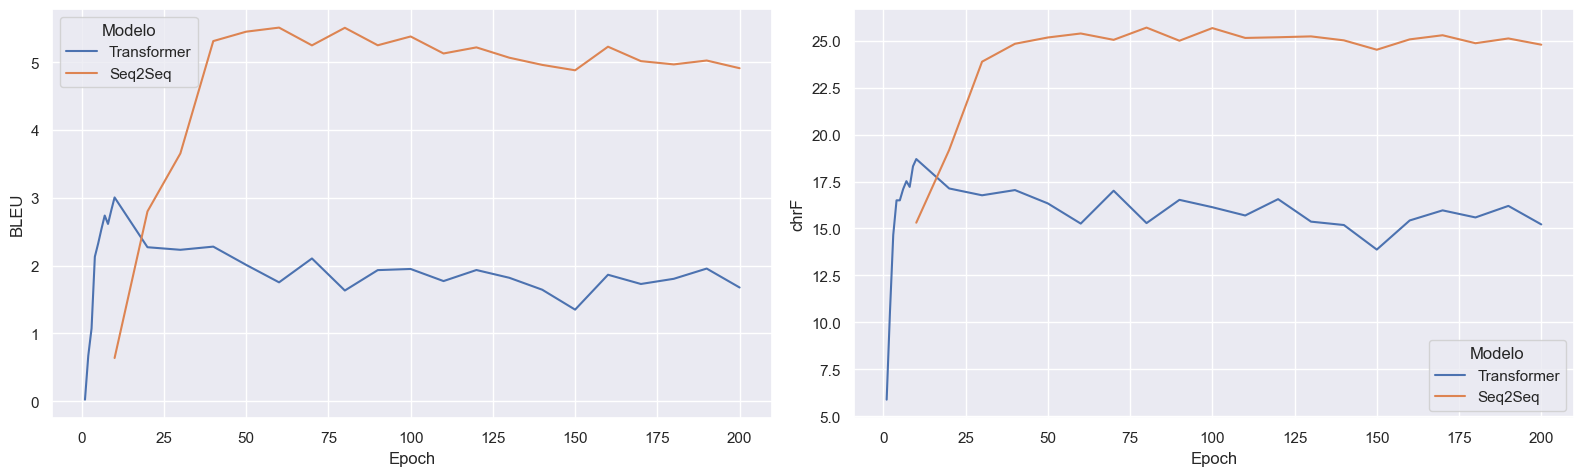

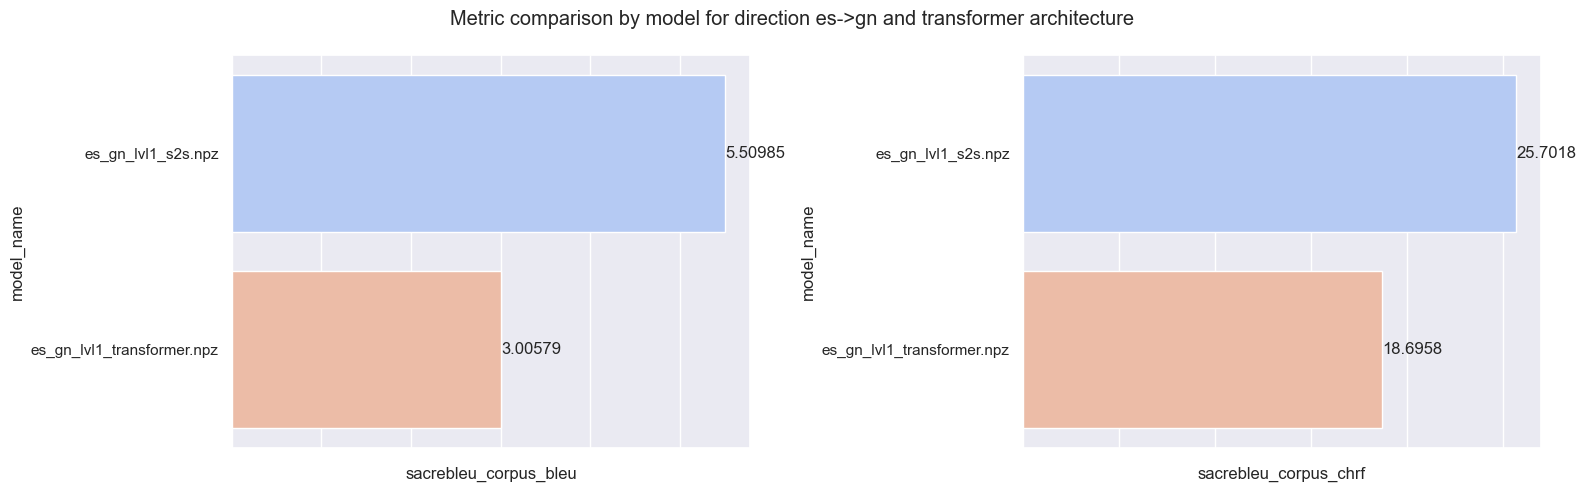

In [332]:
plots.plot_metric_by_epoch_foreach_model(es_gn_results_prettier, 
                                         title='',
                                         metrics=[BLEU_VALUE, CHRF_VALUE],
                                         model_name=MODEL_NAME_VALUE,
                                         score_name=SCORE_VALUE,

                                         save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                                'level1_es_gn_results.png'),
                                         figsize=FIGSIZE_LEVEL1);
plots.plot_max_score_by_model(es_gn_results, 
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=FIGSIZE_LEVEL1);

In [333]:
#lvl1_df.groupby(['source', 'score_type', 'model_name'], group_keys=False).apply(lambda x: x.sort_values('score', ascending=False).head(1)).sort_values(['model_name', 'score_type'])

def get_best_experiment_scores_by_metric(df: pd.DataFrame, 
                                         score_type='sacrebleu_corpus_chrf', 
                                         groupby=['source', 'score_type', 'model_name']):
    return (df[df['score_type']==score_type].groupby(groupby, group_keys=False)
                                            .apply(lambda x: x.sort_values('score', ascending=False)
                                            .head(1)))

def get_every_experiment_score(full_df: pd.DataFrame, experiments_df: pd.DataFrame):
    return (full_df.merge(experiments_df,
                          on=['source', 'model_name', 'epoch'], 
                          how='inner')
                   .sort_values(['score_type_x', 'score_x', 'model_name'], ascending=False))

def pivot_best_experiment_scores(df: pd.DataFrame):
    df = df[['model_name', 'source', 'target_x', 'score_type_x', 'score_x', 'epoch']]
    return df.pivot(index=['model_name', 'source', 'target_x', 'epoch'], 
                    columns='score_type_x', 
                    values='score_x').reset_index()

def get_best_experiment_scores(df: pd.DataFrame, groupby=['source', 'score_type', 'model_name']):
    best_experiment_scores_by_chrf = get_best_experiment_scores_by_metric(df, 
                                                                          score_type='sacrebleu_corpus_chrf', 
                                                                          groupby=groupby)
    best_experiment_scores = get_every_experiment_score(df,
                                                        best_experiment_scores_by_chrf)
    pivoted_best_experiment_scores = pivot_best_experiment_scores(best_experiment_scores)
    return pivoted_best_experiment_scores


get_best_experiment_scores(lvl1_df)

score_type_x                  model_name           source         target_x  \
0                     es_gn_lvl1_s2s.npz  valid_es.txt.es  valid_gn.txt.gn   
1             es_gn_lvl1_transformer.npz  valid_es.txt.es  valid_gn.txt.gn   
2                     gn_es_lvl1_s2s.npz  valid_gn.txt.gn  valid_es.txt.es   
3             gn_es_lvl1_transformer.npz  valid_gn.txt.gn  valid_es.txt.es   

score_type_x  epoch  sacrebleu_corpus_bleu  sacrebleu_corpus_chrf  
0                80               5.507029              25.701832  
1                10               3.005788              18.695834  
2               120               5.828194              30.306721  
3                60               5.583044              26.243839

## **Level 2**

In this section we tested multiple hyperparameters using coordinate-wise optimization
in order to get more interpretable preliminar results.

In [334]:
lvl2_df = pd.read_csv(LVL2_RESULTS)
lvl2_df.tail()

date  \
1083  2023-08-04 18:50:13.247111   
1084  2023-08-04 19:39:19.335075   
1085  2023-08-04 19:39:19.335075   
1086  2023-08-04 20:28:25.415945   
1087  2023-08-04 20:28:25.415945   

                                             model_name           source  \
1083  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1084  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1085  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1086  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1087  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   

               target             score_type      score  epoch  \
1083  valid_es.txt.es  sacrebleu_corpus_bleu  15.481119    380   
1084  valid_es.txt.es  sacrebleu_corpus_chrf  36.378641    390   
1085  valid_es.txt.es  sacrebleu_corpus_bleu  15.409644    390   
1086  valid_es.txt.es  sacrebleu_corpus_chrf  36.290605    400   
1087  valid_es.txt.es  sacrebleu_corpus_bleu  15.194003    400   

                                             parameters  
1083  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1084  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1085  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1086  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1087  {'type': ['s2s'], 'devices': ['0'], 'train-set...

In [335]:
gn_es_lvl2_results = lvl2_df[lvl2_df['source'].str.contains('gn', regex=False)]
es_gn_lvl2_results = lvl2_df[lvl2_df['source'].str.contains('es', regex=False)]

In [336]:
gn_es_results_lvl2_prettier = df_prettier(gn_es_lvl2_results, level=2)
es_gn_results_lvl2_prettier = df_prettier(es_gn_lvl2_results, level=2)

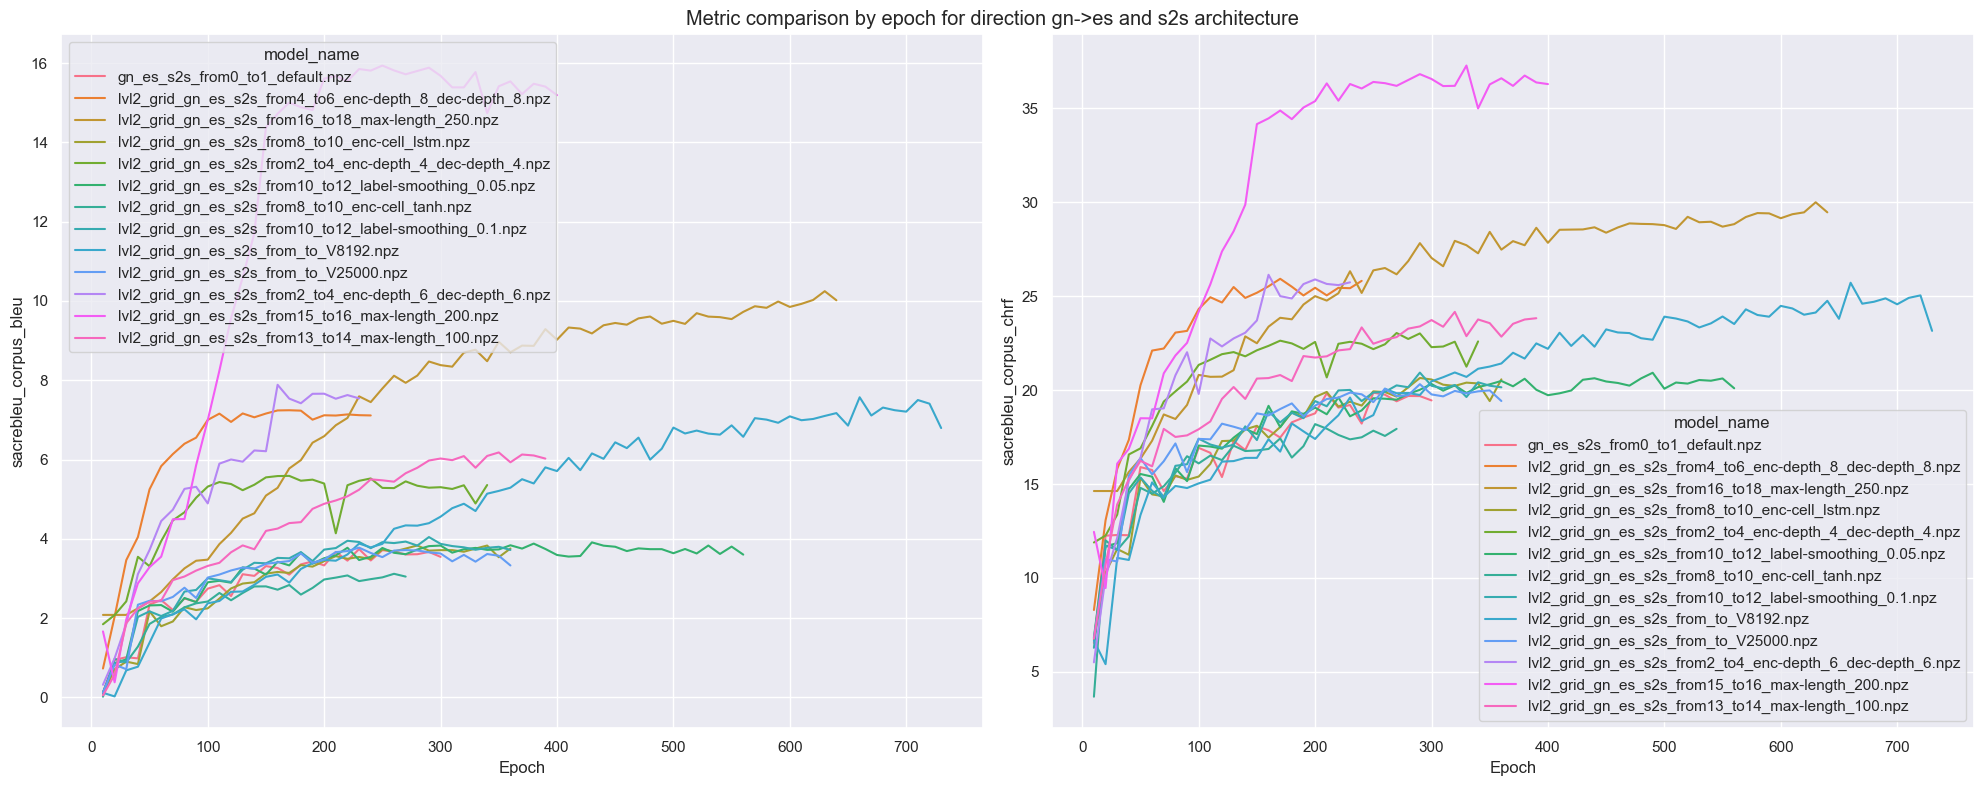

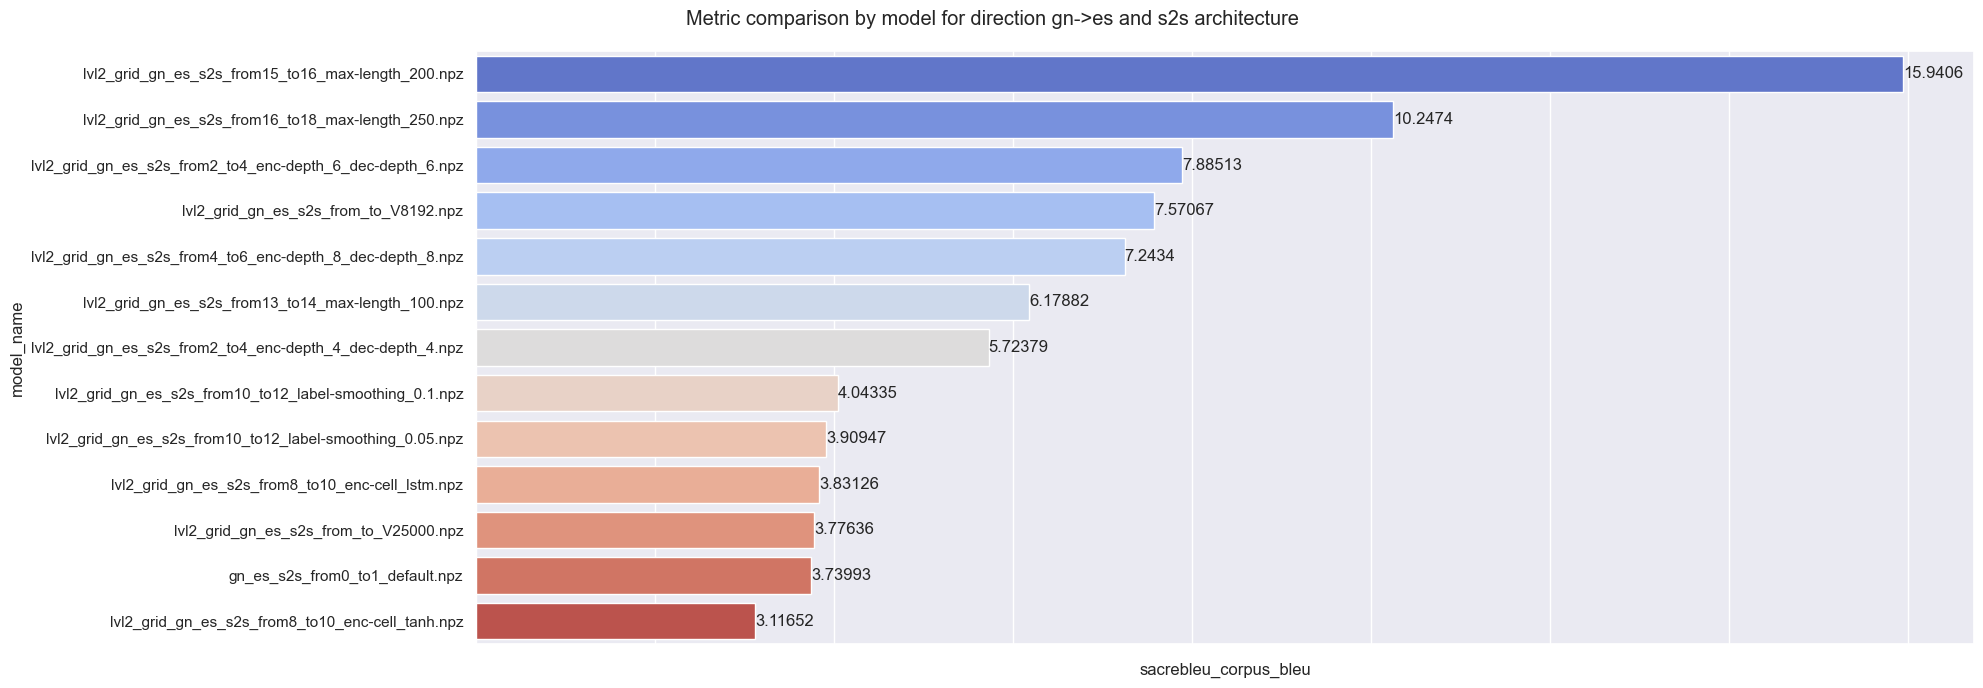

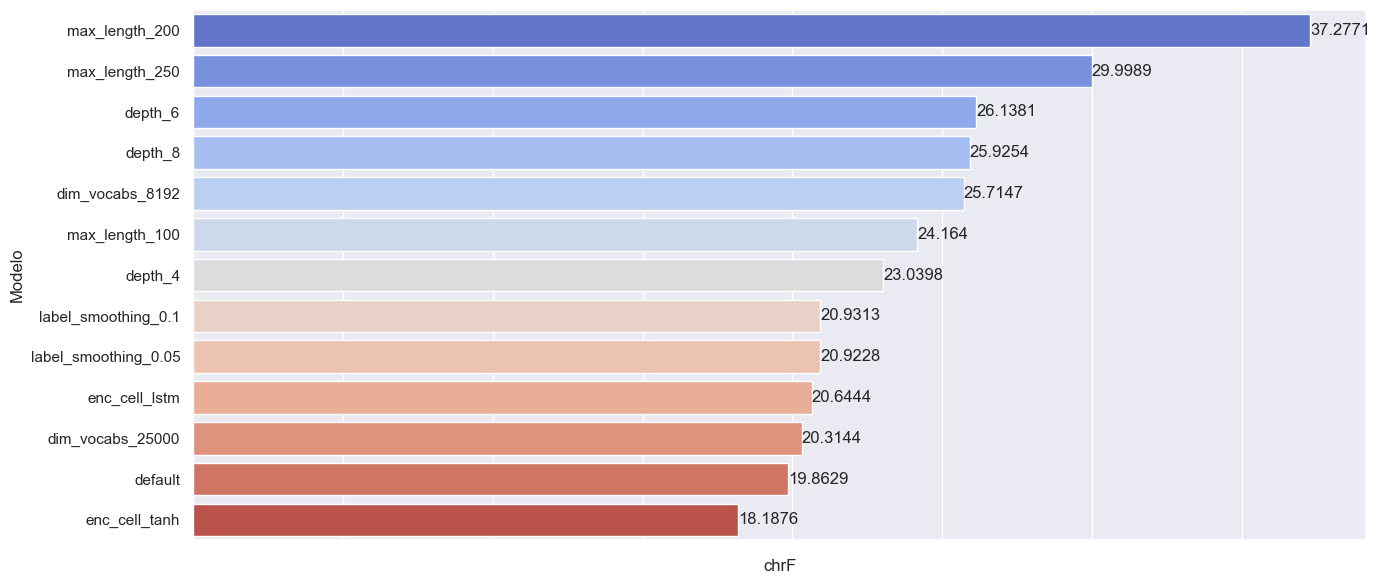

In [337]:
plots.plot_metric_by_epoch_foreach_model(gn_es_lvl2_results, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=(20,8));
plots.plot_max_score_by_model(gn_es_lvl2_results, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7))
plots.plot_max_score_by_model(gn_es_results_lvl2_prettier, 
                              metrics=[CHRF_VALUE], 
                              model_name=MODEL_NAME_VALUE,
                              score_name=SCORE_VALUE,
                              sort_by=SCORE_VALUE,
                              y_col=MODEL_NAME_VALUE,
                              title='',
                              save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                     'level2_gn_es_results.png'),
                              figsize=(14,6))

In [338]:
get_best_experiment_scores(lvl2_df)

score_type_x                                         model_name  \
0                               gn_es_s2s_from0_to1_default.npz   
1             lvl2_grid_gn_es_s2s_from10_to12_label-smoothin...   
2             lvl2_grid_gn_es_s2s_from10_to12_label-smoothin...   
3             lvl2_grid_gn_es_s2s_from13_to14_max-length_100...   
4             lvl2_grid_gn_es_s2s_from15_to16_max-length_200...   
5             lvl2_grid_gn_es_s2s_from16_to18_max-length_250...   
6             lvl2_grid_gn_es_s2s_from2_to4_enc-depth_4_dec-...   
7             lvl2_grid_gn_es_s2s_from2_to4_enc-depth_6_dec-...   
8             lvl2_grid_gn_es_s2s_from4_to6_enc-depth_8_dec-...   
9              lvl2_grid_gn_es_s2s_from8_to10_enc-cell_lstm.npz   
10             lvl2_grid_gn_es_s2s_from8_to10_enc-cell_tanh.npz   
11                       lvl2_grid_gn_es_s2s_from_to_V25000.npz   
12                        lvl2_grid_gn_es_s2s_from_to_V8192.npz   

score_type_x           source         target_x  epoch  sacrebleu_corpus_bleu  \
0             valid_gn.txt.gn  valid_es.txt.es    250               3.713158   
1             valid_gn.txt.gn  valid_es.txt.es    490               3.738219   
2             valid_gn.txt.gn  valid_es.txt.es    290               4.043353   
3             valid_gn.txt.gn  valid_es.txt.es    320               6.086404   
4             valid_gn.txt.gn  valid_es.txt.es    330              15.776506   
5             valid_gn.txt.gn  valid_es.txt.es    630              10.247390   
6             valid_gn.txt.gn  valid_es.txt.es    270               5.448664   
7             valid_gn.txt.gn  valid_es.txt.es    160               7.885129   
8             valid_gn.txt.gn  valid_es.txt.es    170               7.243399   
9             valid_gn.txt.gn  valid_es.txt.es    290               3.700672   
10            valid_gn.txt.gn  valid_es.txt.es    200               2.973063   
11            valid_gn.txt.gn  valid_es.txt.es    290               3.659151   
12            valid_gn.txt.gn  valid_es.txt.es    660               7.570673   

score_type_x  sacrebleu_corpus_chrf  
0                         19.862937  
1                         20.922784  
2                         20.931333  
3                         24.163997  
4                         37.277129  
5                         29.998861  
6                         23.039828  
7                         26.138085  
8                         25.925366  
9                         20.644400  
10                        18.187602  
11                        20.314355  
12                        25.714738

### **Level 2 metrics by hyperparameter**

```
- (enc-depth, dec-depth):   [(1, 1) {default}, (2, 2), (4, 4), (6, 6), (8, 8)]
- enc-cell:                 ["lstm", "tanh", "gru" {default}]
- sentencepiece-dim-vocabs: [2^13, 2^14 {our default}, 2^15]
- label-smoothing:          [0 {default}, 0.05, 0.1]
- max-length:               [100, 150, 200, 250]
```

In [339]:
def extract_features(lvl1_df: pd.DataFrame, lvl2_df: pd.DataFrame, feature: str, column='parameters'):
    filtered_df = lvl2_df[lvl2_df[column].str.contains(feature)]
    default_df = lvl2_df[lvl2_df['model_name'].str.contains('default')]
    filtered_df = pd.concat([default_df, filtered_df])
    
    #lvl1_results = lvl1_df[lvl1_df['model_name'].str.contains('lvl1')]
    #filtered_df = pd.concat([filtered_df, lvl1_results])

    return filtered_df

#### **GN -> ES**

##### **Seq2Seq**

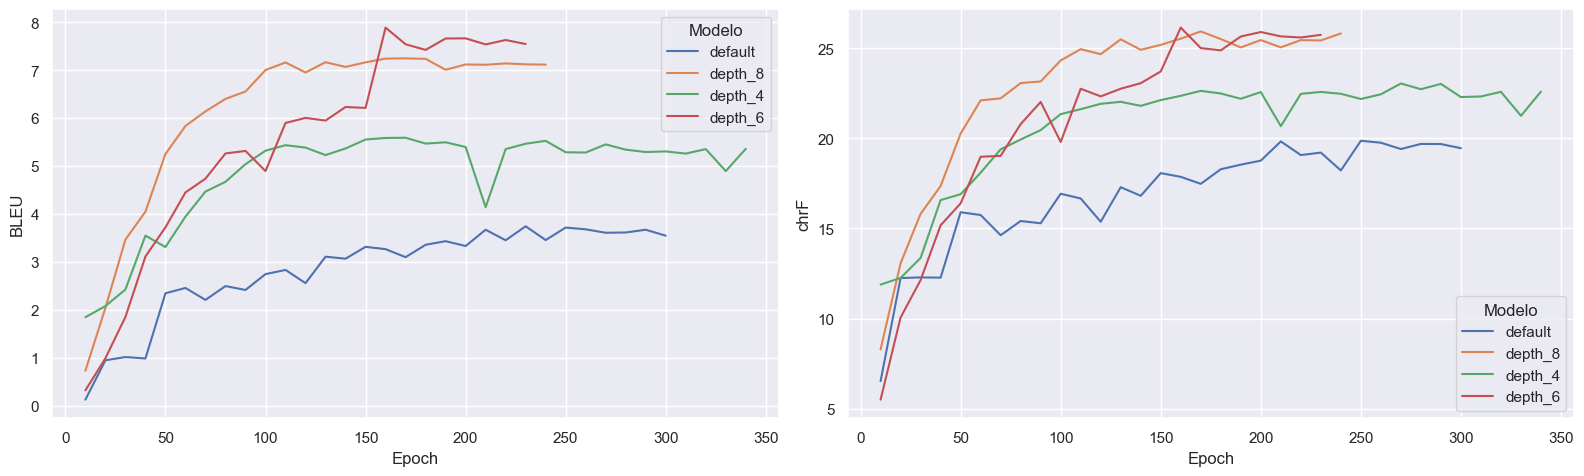

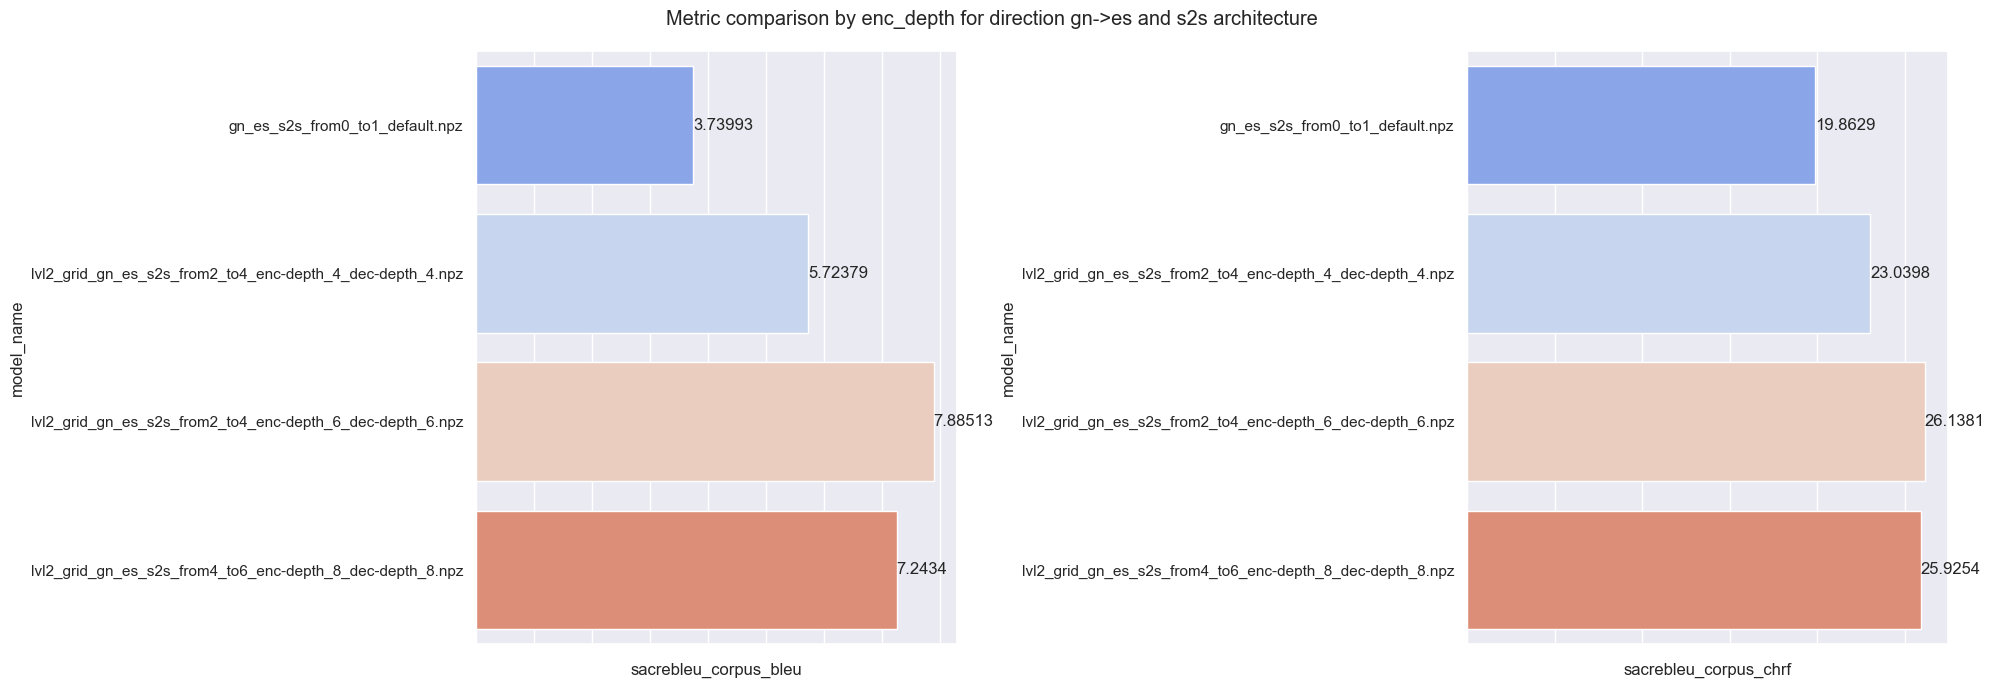

In [340]:
enc_dec_depth_df = extract_features(gn_es_results, 
                                    gn_es_lvl2_results, 
                                    'enc-depth')
enc_dec_depth_prettier_df = df_prettier(enc_dec_depth_df, level=2)

plots.plot_metric_by_epoch_foreach_model(enc_dec_depth_prettier_df,
                                         title='',
                                         metrics=[BLEU_VALUE, CHRF_VALUE],
                                        model_name=MODEL_NAME_VALUE,
                                        score_name=SCORE_VALUE,
                                        save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                               'level2_enc_dec_depth_results.png'),
                                         figsize=(16,5));

enc_dec_depth_df_sorted_by_depth = enc_dec_depth_df.copy()
enc_dec_depth_df_sorted_by_depth['enc_depth'] = [int(x[-5]) if 'enc-depth' in x else 1 \
                                                 for x in enc_dec_depth_df_sorted_by_depth['model_name']]
plots.plot_max_score_by_model(enc_dec_depth_df_sorted_by_depth, 
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=(20,7), 
                              by='enc_depth', 
                              sort_by='enc_depth', 
                              ascending=True);

**Encoder Cell**

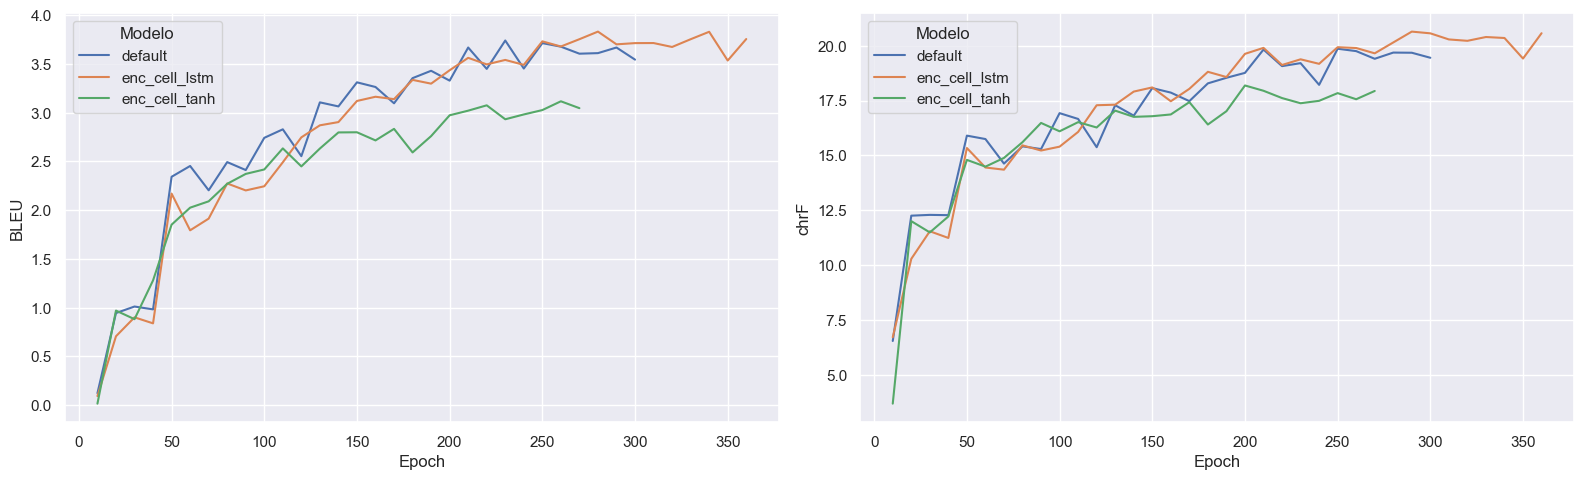

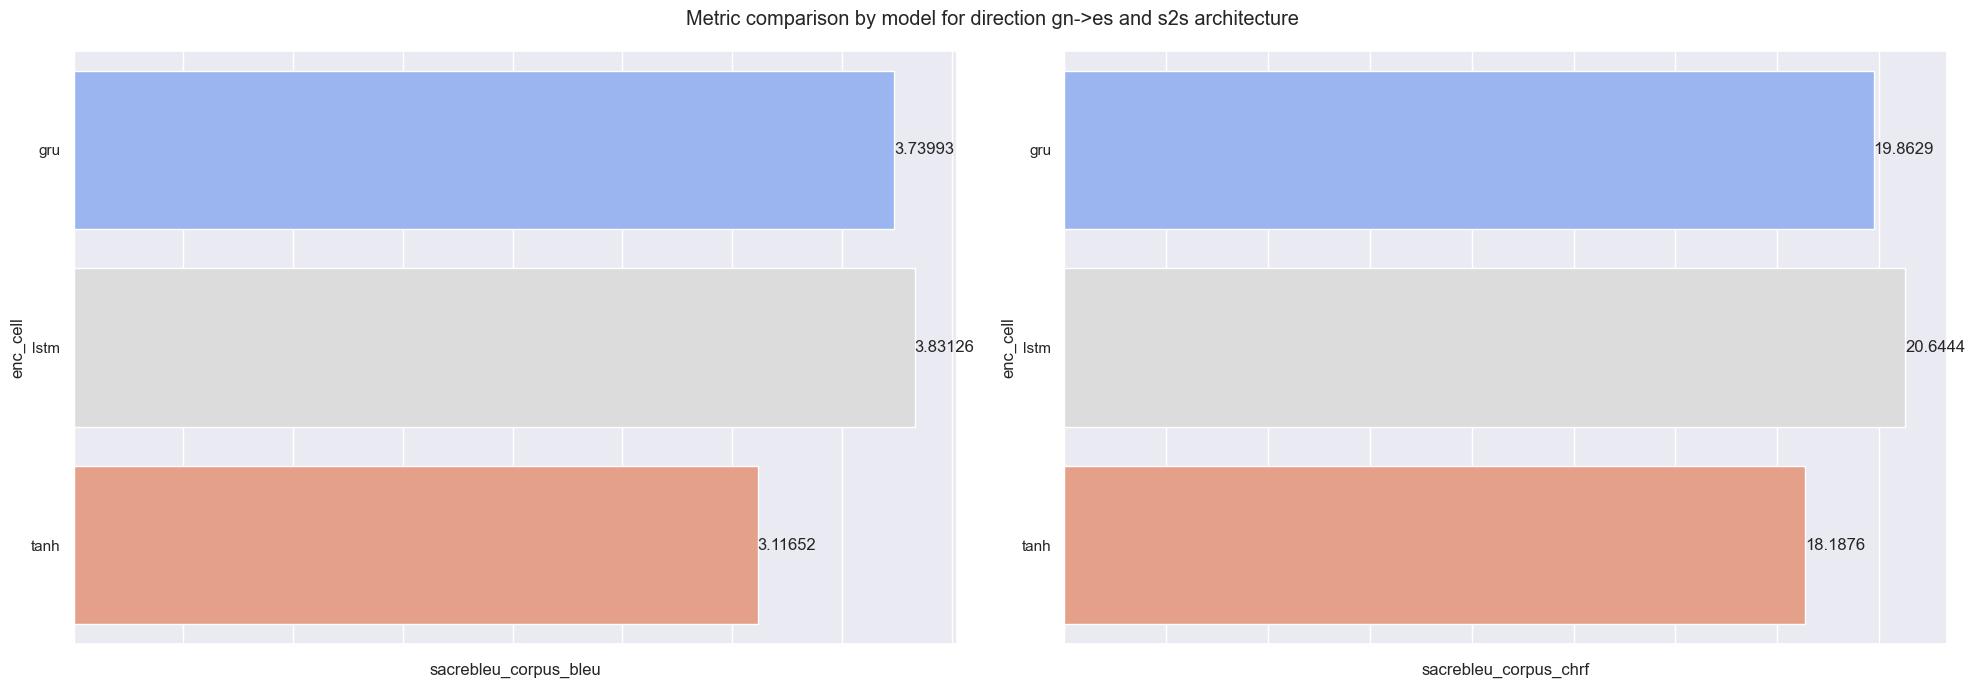

In [341]:
enc_cell_df = extract_features(gn_es_results, 
                               gn_es_lvl2_results, 
                               'enc-cell')
enc_cell_prettier_df = df_prettier(enc_cell_df, level=2)
plots.plot_metric_by_epoch_foreach_model(enc_cell_prettier_df,
                                         title='',
                                         metrics=[BLEU_VALUE, CHRF_VALUE],
                                        model_name=MODEL_NAME_VALUE,
                                        score_name=SCORE_VALUE,
                                        save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                               'level2_enc_cell_results.png'),
                                         figsize=(16,5));

enc_cell_df['enc_cell'] = [x[-8:-4] if 'enc-cell' in x else 'gru' \
                           for x in enc_cell_df['model_name']]
plots.plot_max_score_by_model(enc_cell_df, 
                              metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], 
                              figsize=(20,7), 
                              y_col='enc_cell', 
                              sort_by='enc_cell', 
                              ascending=True);

**Sentence Piece Vocab Size**

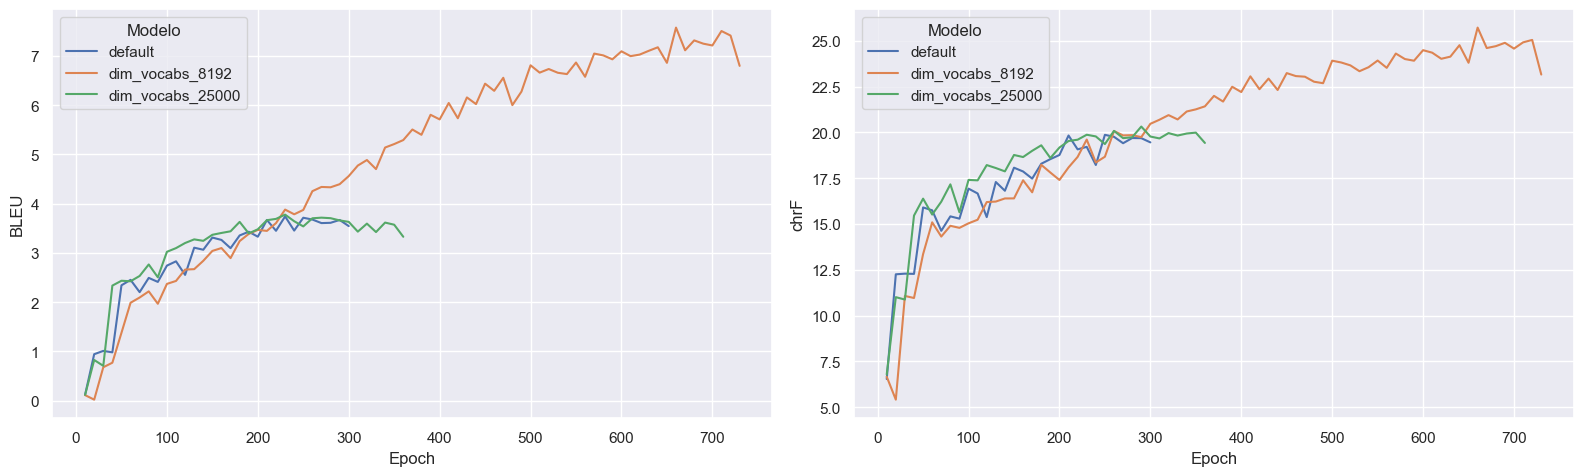

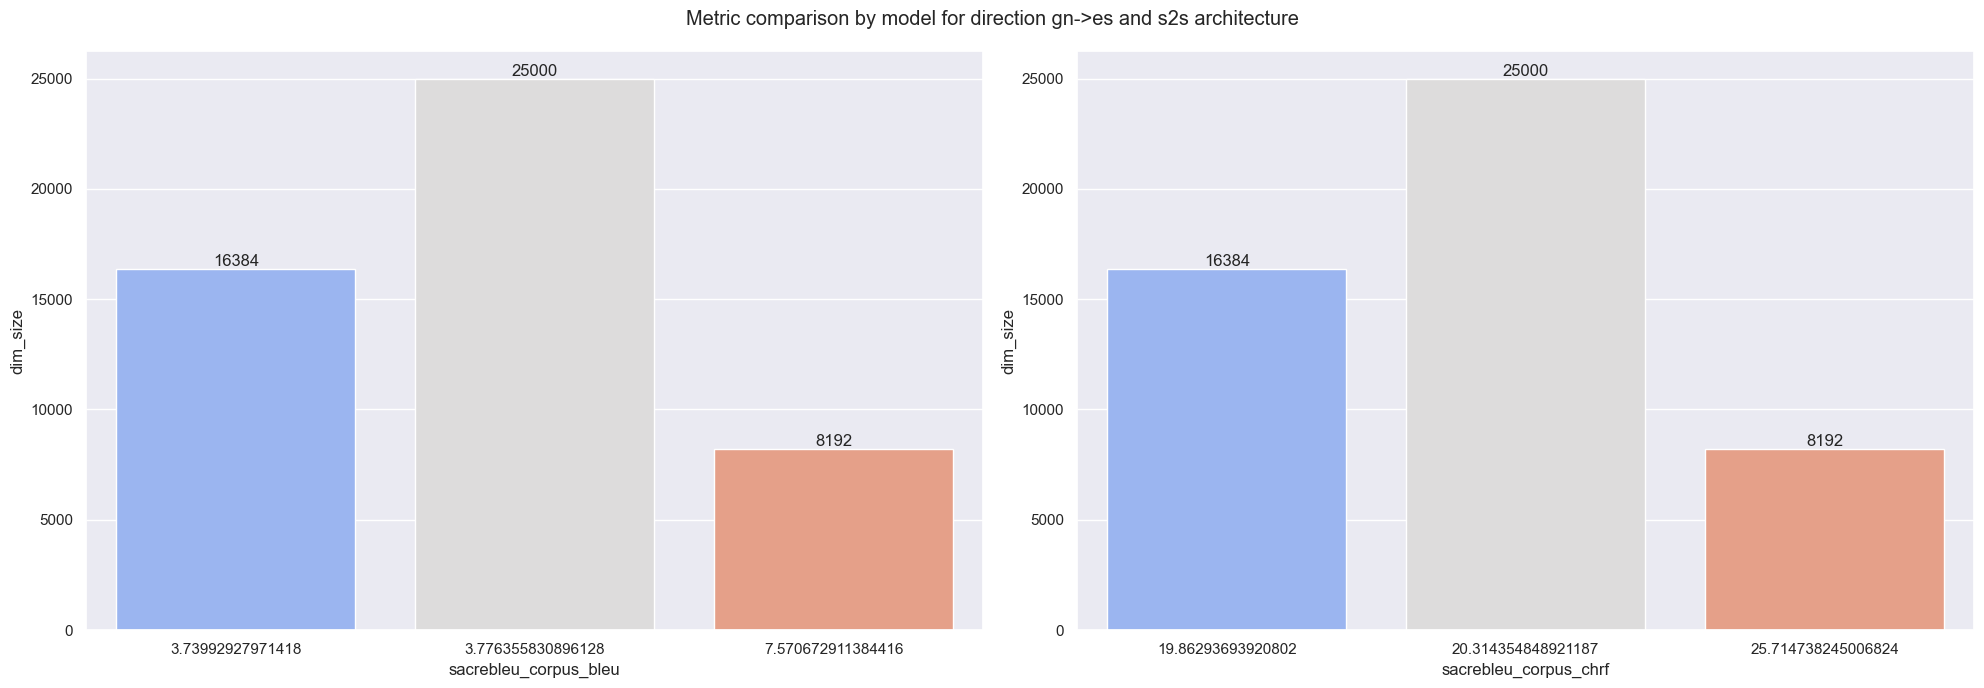

In [342]:
dim_size_df = extract_features(gn_es_results, 
                               gn_es_lvl2_results, 
                               '_V', 
                               column='model_name')
dim_size_prettier_df = df_prettier(dim_size_df, level=2)
plots.plot_metric_by_epoch_foreach_model(dim_size_prettier_df,
                                         title='',
                                         metrics=[BLEU_VALUE, CHRF_VALUE],
                                        model_name=MODEL_NAME_VALUE,
                                        score_name=SCORE_VALUE,
                                        save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                               'level2_dim_size_results.png'),
                                         figsize=(16,5));

dim_size_df['dim_size'] = [int(x[-9:-4].replace('V','')) if 'V' in x \
                           else 2**14 \
                           for x in dim_size_df['model_name']]
plots.plot_max_score_by_model(dim_size_df,
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=(20,7), 
                              y_col='dim_size', 
                              sort_by='dim_size', 
                              ascending=True);

**Label smoothing**

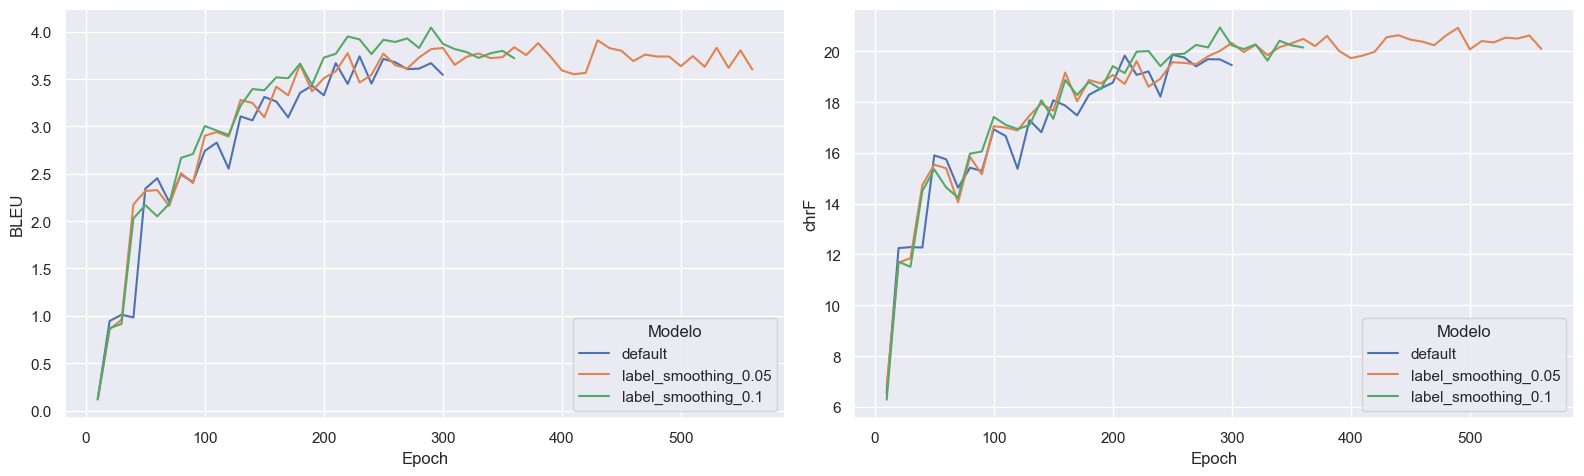

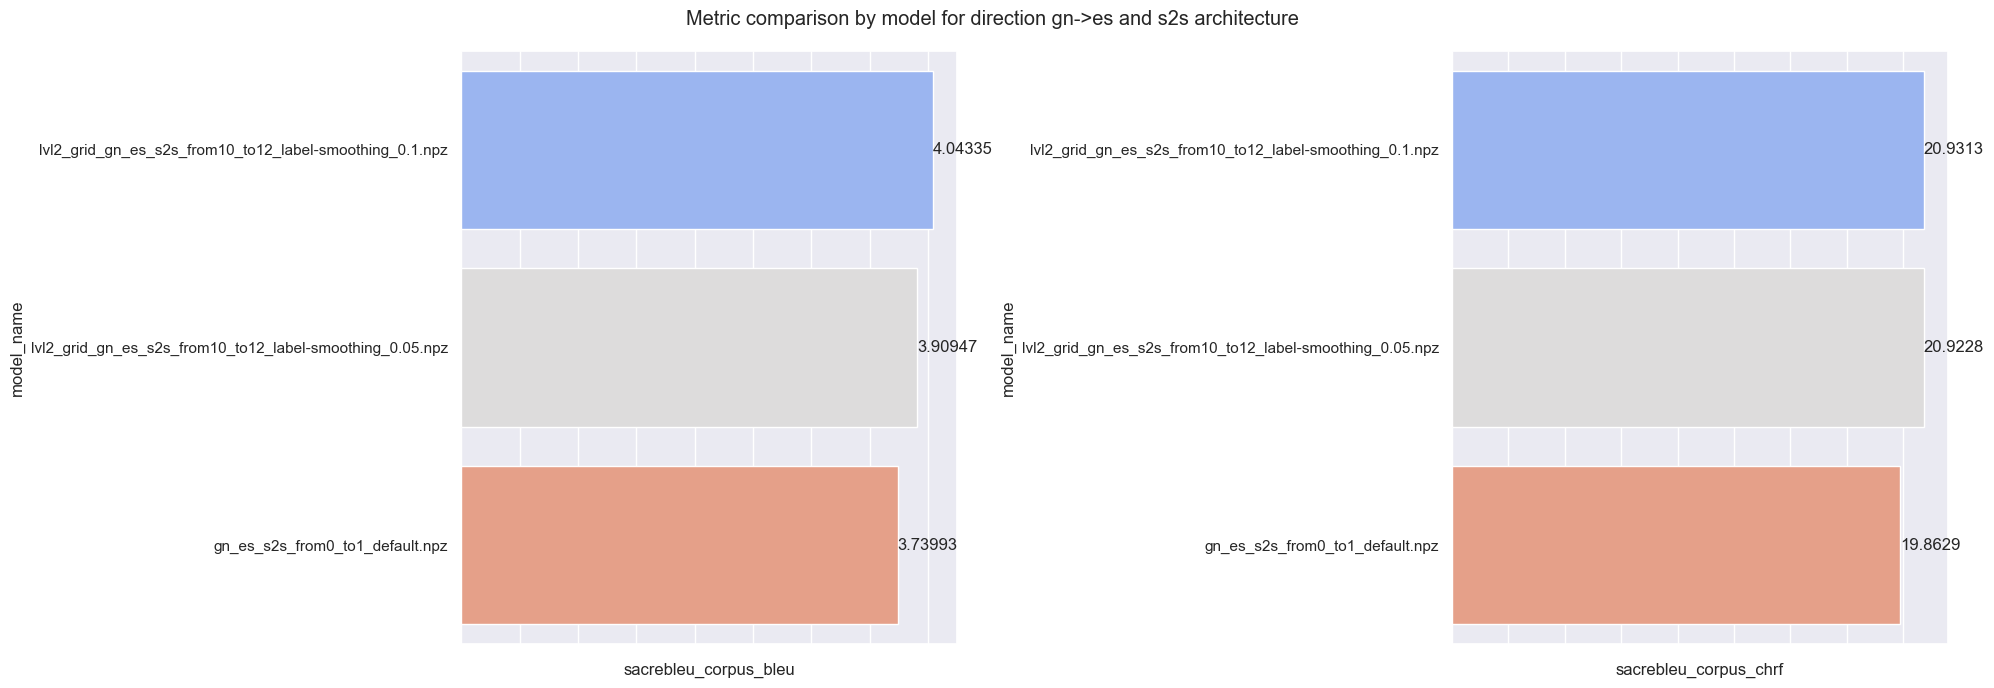

In [343]:
label_smoothing_df = extract_features(gn_es_results,
                                    gn_es_lvl2_results,
                                    'label-smoothing')
label_smoothing_prettier_df = df_prettier(label_smoothing_df, level=2)
plots.plot_metric_by_epoch_foreach_model(label_smoothing_prettier_df,
                                         title='',
                                         metrics=[BLEU_VALUE, CHRF_VALUE],
                                        model_name=MODEL_NAME_VALUE,
                                        score_name=SCORE_VALUE,
                                        save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                               'level2_label_smoothing_results.png'),
                                         figsize=(16,5));

plots.plot_max_score_by_model(label_smoothing_df,
                              metrics=['sacrebleu_corpus_bleu',
                                       'sacrebleu_corpus_chrf'],
                              figsize=(20,7));

**Sentence max length**

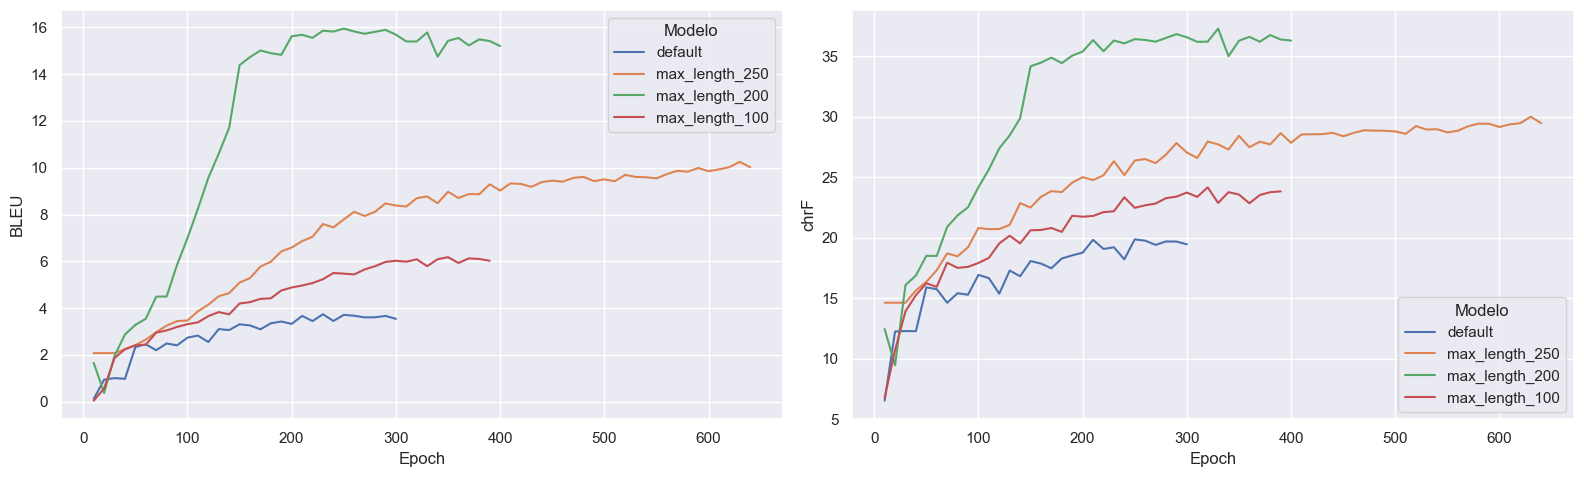

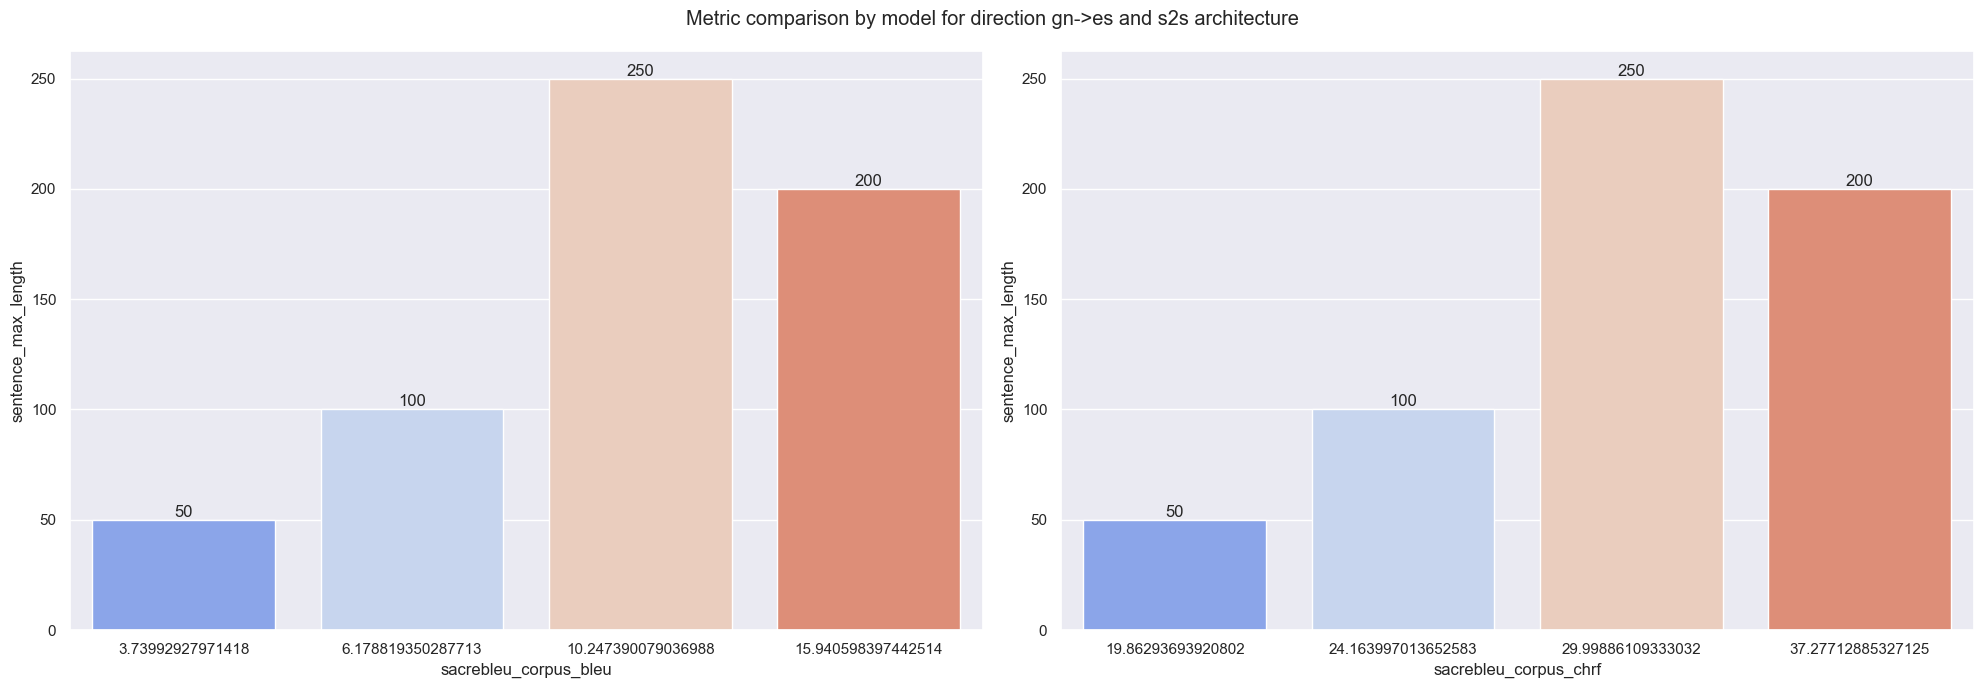

In [344]:
sentence_max_length_df = extract_features(gn_es_results, gn_es_lvl2_results,
                                          'max-length',
                                          column='model_name')

sentence_max_length_prettier_df = df_prettier(sentence_max_length_df, level=2)
plots.plot_metric_by_epoch_foreach_model(sentence_max_length_prettier_df,
                                         title='',
                                         metrics=[BLEU_VALUE, CHRF_VALUE],
                                        model_name=MODEL_NAME_VALUE,
                                        score_name=SCORE_VALUE,
                                        save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                               'level2_max_length_results.png'),
                                         figsize=(16,5));

sentence_max_length_df['sentence_max_length'] = [int(x[-7:-4]) if 'max-length' in x \
                                                 else 50 \
                                                 for x in sentence_max_length_df['model_name']]
plots.plot_max_score_by_model(sentence_max_length_df,
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'],
                              figsize=(20,7),
                              y_col='sentence_max_length',
                              sort_by='sentence_max_length',
                              ascending=True);

## **Level 3**

**Hyperparameters:**

```
- (enc-depth, dec-depth):   [(1, 1) {default}, (4, 4), (6, 6), (8, 8)]
- sentencepiece-dim-vocabs: [2^13, 2^14 {our default}, 2^15]
- label-smoothing:          [0 {default}, 0.05, 0.1]
- max-length:               [100, 200, 250]
- crop-max-length:          [true {our default}]

```

##### **S2S: GN -> ES**

In [345]:
gn_es_lvl3_results_df = pd.read_csv(LVL3_S2S_GN_ES_RESULTS)
gn_es_lvl3_results_df.tail()

date  \
969  2023-09-03 03:47:19.557109   
970  2023-09-03 04:35:15.158963   
971  2023-09-03 04:35:15.158963   
972  2023-09-03 05:22:16.909329   
973  2023-09-03 05:22:16.909329   

                                            model_name           source  \
969  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
970  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
971  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
972  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
973  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   

              target             score_type      score  epoch  \
969  valid_es.txt.es  sacrebleu_corpus_bleu  12.401415    100   
970  valid_es.txt.es  sacrebleu_corpus_chrf  34.882414    110   
971  valid_es.txt.es  sacrebleu_corpus_bleu  15.352581    110   
972  valid_es.txt.es  sacrebleu_corpus_chrf  12.611827    120   
973  valid_es.txt.es  sacrebleu_corpus_bleu   0.969541    120   

                                            parameters  
969  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
970  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
971  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
972  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
973  {'type': ['s2s'], 'max-length-crop': [], 'drop...

In [346]:
gn_es_lvl3_results_df_prettier = df_prettier(gn_es_lvl3_results_df, level=3)

In [347]:
def get_best_scores(pretty_results_df: pd.DataFrame):
    best_models_models_by_chrf = pretty_results_df[pretty_results_df['score_type']=='chrF'][['Modelo', 'source', 'target', 'score_type', 'Desempeño', 'epoch']].groupby(['Modelo', 'score_type']).apply(lambda x: x.sort_values('Desempeño', ascending=False).head(1)).reset_index(drop=True).sort_values(['Desempeño'], ascending=False)
    best_models = pretty_results_df.merge(best_models_models_by_chrf, on=['Modelo', 'epoch'], how='inner')
    best_models = best_models.drop_duplicates(subset=['Modelo', 'score_type_x', 'epoch', 'score_type_y'])
    best_models = best_models[best_models['score_type_x']=='BLEU']


    # Extract hyperparameters
    learn_rate =  best_models['Modelo'].apply(lambda x: re.findall(r'lr_([^_]+)', x)[0])
    best_models['learn-rate'] = learn_rate

    max_length = best_models['Modelo'].apply(lambda x: re.findall(r'maxlen_(\d+)', x)[0])
    best_models['max-length'] = max_length

    enc_depth = best_models['Modelo'].apply(lambda x: re.findall(r'depth_(\d+)', x)[0])
    best_models['depth'] = enc_depth

    dim_vocabs = best_models['Modelo'].apply(lambda x: re.findall(r'dimvocabs_(\d+)', x)[0])
    best_models['dim-vocabs'] = dim_vocabs

    # Column and value renaming
    best_models.rename(columns={'Desempeño_x': 'BLEU',
                                      'Desempeño_y': 'chrF',
                                      'source_x': 'Origen',
                                      'target_x': 'Destino',
                                      'epoch': 'Epoch'},
                            inplace=True)
    
    rename_dataset = lambda x: 'gn' if '.gn' in x else 'es'
    best_models['Origen'] = best_models['Origen'].apply(rename_dataset)
    best_models['Destino'] = best_models['Destino'].apply(rename_dataset)
    
    best_models['Arquitectura'] = best_models['parameters'].str.contains('transformer').apply(lambda x: 'transformer' if x else 's2s')
    best_models = best_models[['Arquitectura', 'Origen', 'Destino', 'learn-rate', 'max-length', 'depth', 'dim-vocabs','Epoch', 'BLEU', 'chrF']]

    # Round 2
    best_models['BLEU'] = best_models['BLEU'].apply(lambda x: round(x, 2))
    best_models['chrF'] = best_models['chrF'].apply(lambda x: round(x, 2))
    best_models = best_models.sort_values(['chrF'], ascending=False)
    return best_models

best_s2s_gn_es_models = get_best_scores(gn_es_lvl3_results_df_prettier)
best_s2s_gn_es_models.to_csv(os.path.join(FINAL_DOCUMENT_PATH, 'best_s2s_gn_es_models.csv'), index=False)
best_s2s_gn_es_models


Arquitectura Origen Destino learn-rate max-length depth dim-vocabs  Epoch  \
23          s2s     gn      es     0.0016        187     6       6000    240   
29          s2s     gn      es     0.0014        186     6       2000     50   
9           s2s     gn      es    0.00012        150     4       6000    180   
11          s2s     gn      es    0.00070        180     6       6000    130   
37          s2s     gn      es      0.011        201     4       2000     30   
27          s2s     gn      es    0.00053        177     6       8000    340   
33          s2s     gn      es    0.00062        179     4       6000     40   
1           s2s     gn      es    0.00042        175     5       8000     50   
35          s2s     gn      es     0.0014        186     5       8000     80   
41          s2s     gn      es     0.0029        191     5       8000     70   
31          s2s     gn      es    0.00054        178     6       8000    120   
39          s2s     gn      es    0.00036        173     6       8000     70   
5           s2s     gn      es    0.00017        161     5      10000    120   
13          s2s     gn      es     0.0053        196     7       8000     90   
45          s2s     gn      es    0.00018        162     6      10000     80   
47          s2s     gn      es     0.0057        196     6       6000     50   
25          s2s     gn      es      0.012        202     7       8000     60   
43          s2s     gn      es     0.0066        197     6      10000     40   
7           s2s     gn      es     0.0031        192     7       8000    160   

     BLEU   chrF  
23  25.37  47.32  
29  25.06  47.06  
9   24.34  46.39  
11  24.33  46.02  
37  23.99  45.89  
27  24.33  45.85  
33  23.95  45.80  
1   23.34  45.35  
35  23.72  45.34  
41  23.90  45.30  
31  23.77  45.22  
39  23.57  45.21  
5   23.05  44.77  
13  23.12  44.59  
45  22.97  44.47  
47  22.85  44.03  
25  19.17  40.01  
43  18.32  38.33  
7   12.17  29.93

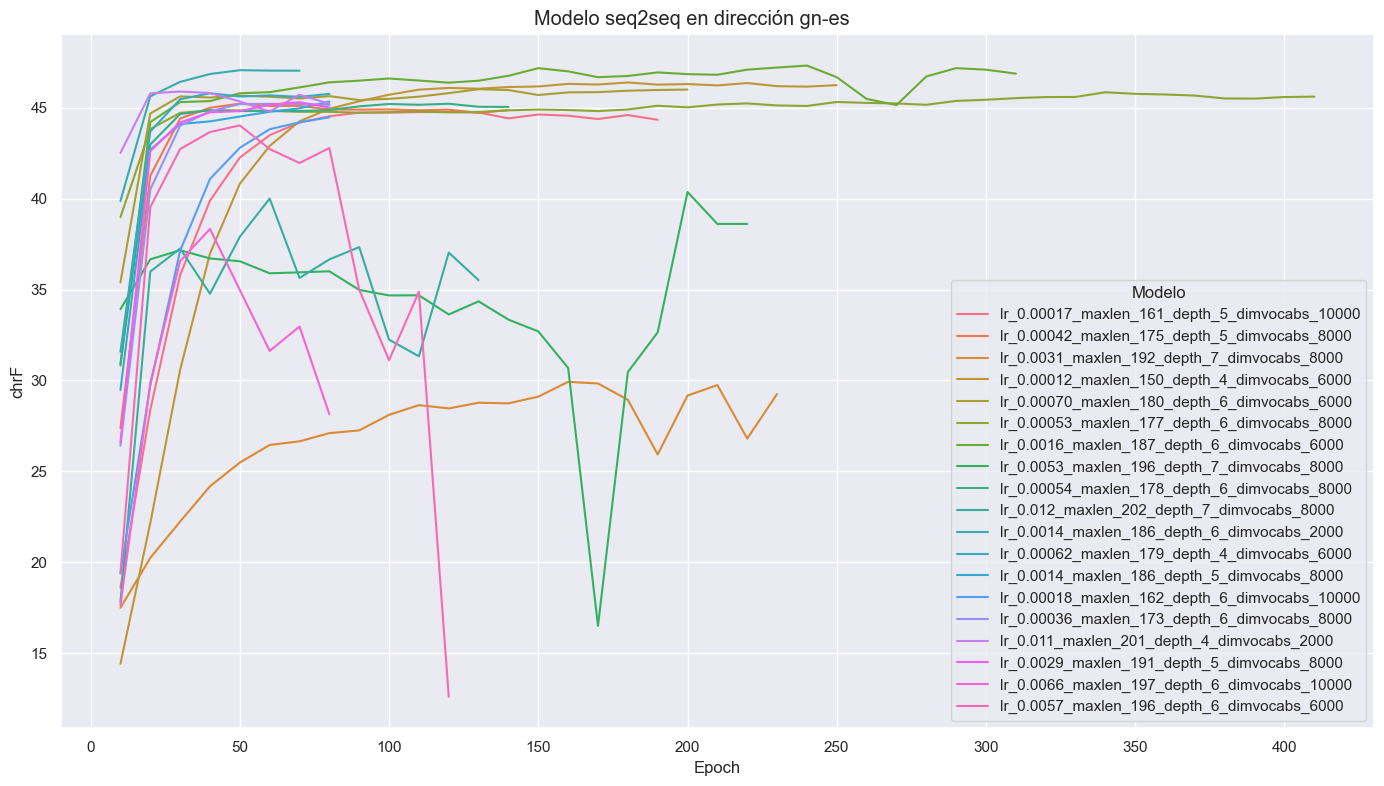

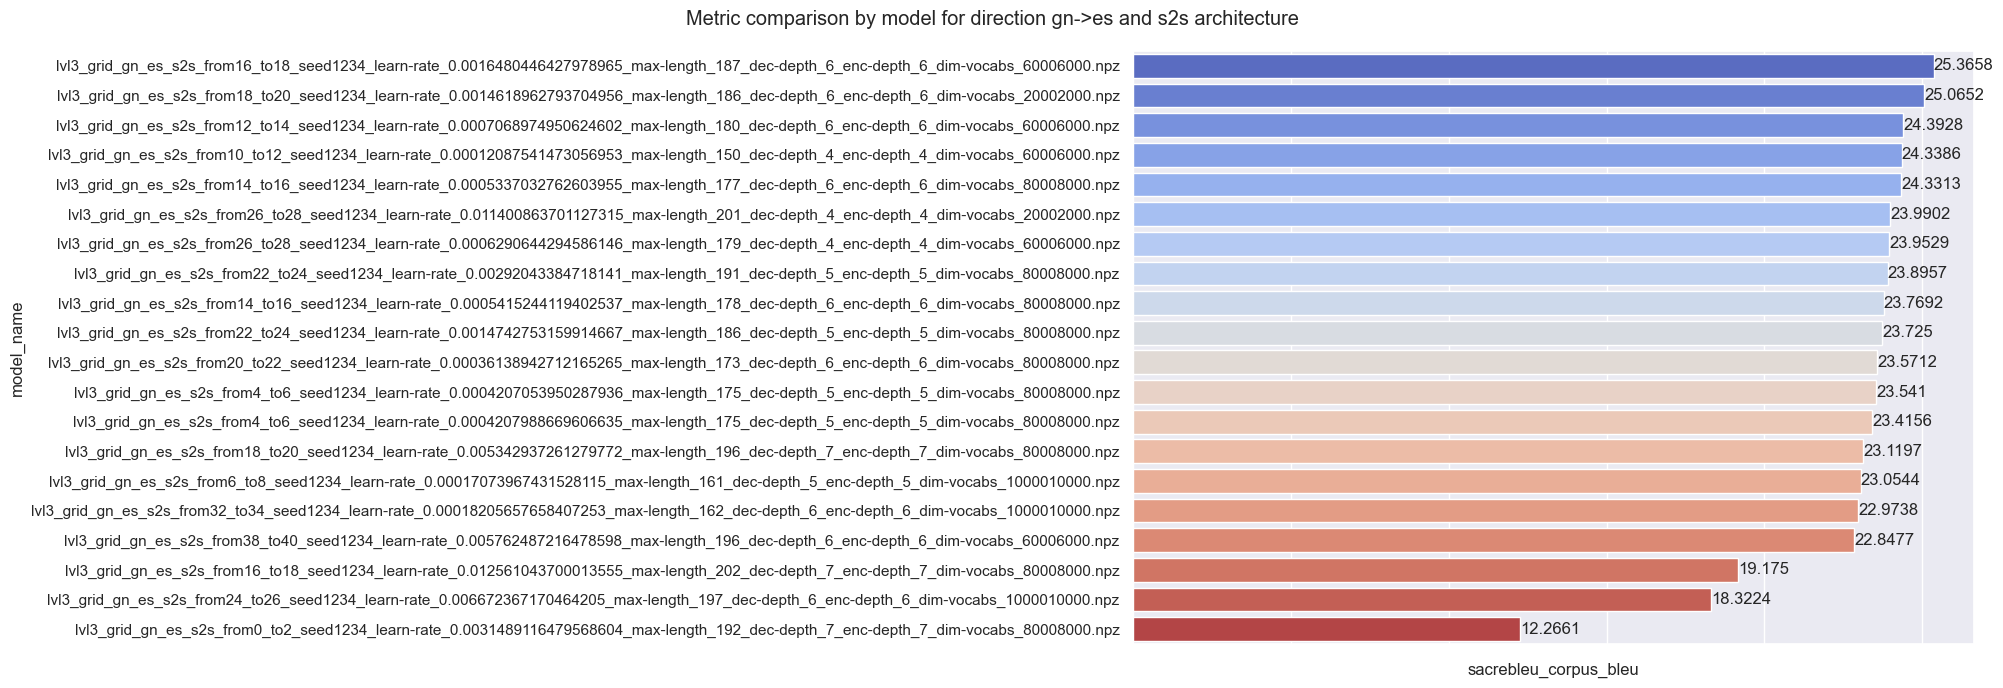

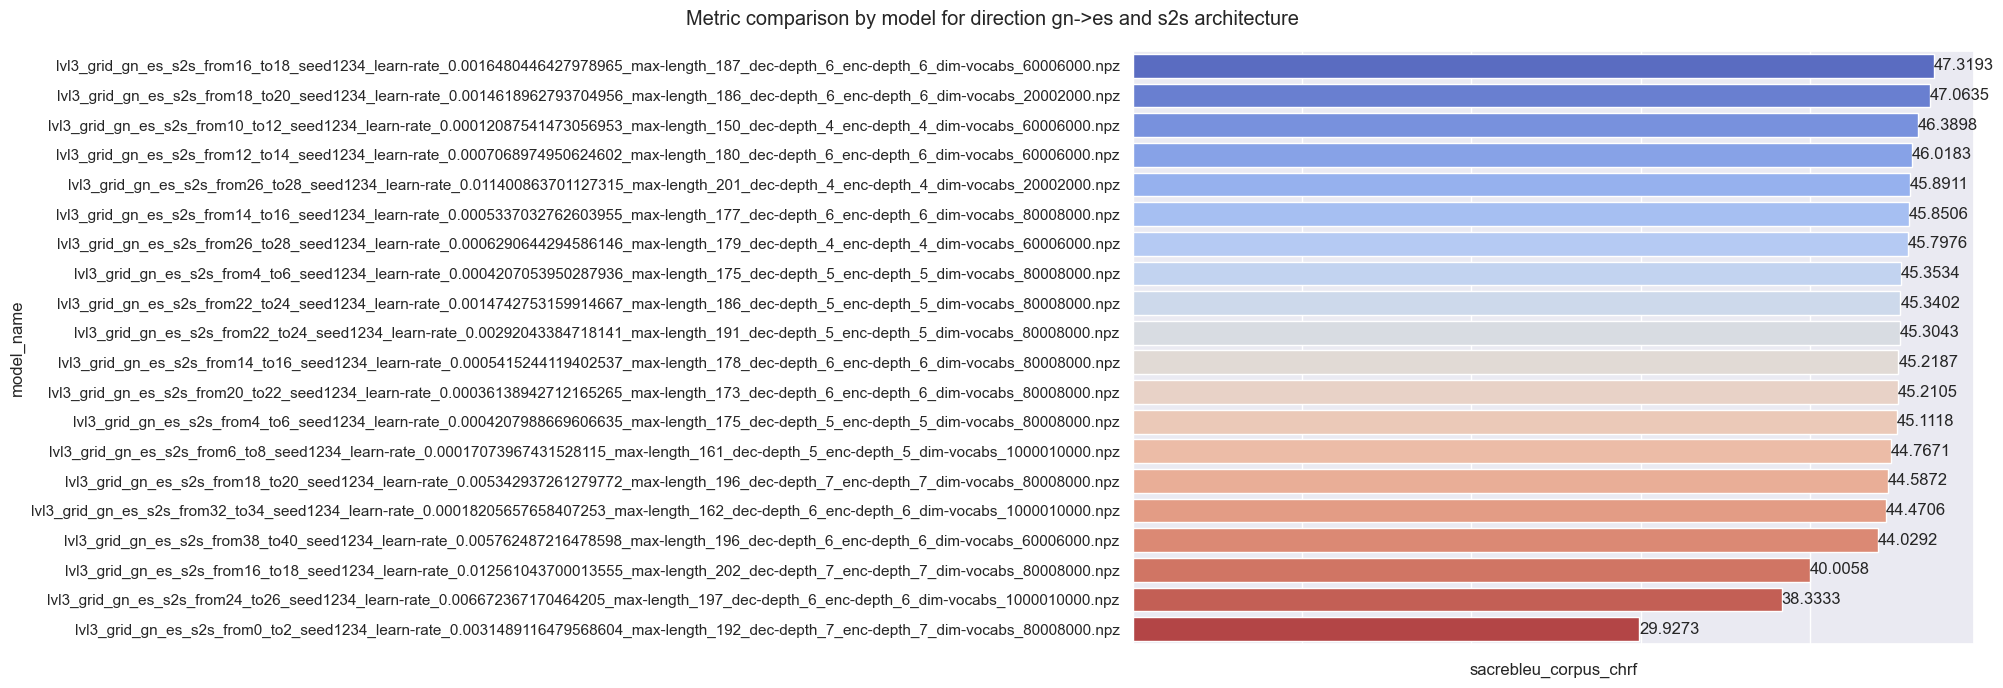

In [348]:
plots.plot_metric_by_epoch_foreach_model(gn_es_lvl3_results_df_prettier,
                                         metrics=[CHRF_VALUE],
                                         model_name=MODEL_NAME_VALUE,
                                         score_name=SCORE_VALUE,
                                         title='Modelo seq2seq en dirección gn-es',
                                         save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                                 'level3_s2s_gn_es_results.png'),
                                         figsize=(14,8), 
                                         legend=True,
                                         tight_layout=True);
plots.plot_max_score_by_model(gn_es_lvl3_results_df,
                              metrics=['sacrebleu_corpus_bleu'],
                              figsize=(20,7));
plots.plot_max_score_by_model(gn_es_lvl3_results_df,
                              metrics=['sacrebleu_corpus_chrf'],
                              figsize=(20,7));

In [349]:
best_model_s2s_gn_es = gn_es_lvl3_results_df.sort_values('score', 
                                                         ascending=False).head(1)
gn_es_lvl3_results_df[gn_es_lvl3_results_df['parameters']==best_model_s2s_gn_es['parameters'].values[0]].tail(2)

date  \
364  2023-08-11 12:34:16.724134   
365  2023-08-11 12:34:16.724134   

                                            model_name           source  \
364  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   
365  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   

              target             score_type      score  epoch  \
364  valid_es.txt.es  sacrebleu_corpus_chrf  47.319293    240   
365  valid_es.txt.es  sacrebleu_corpus_bleu  25.365785    240   

                                            parameters  
364  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
365  {'type': ['s2s'], 'max-length-crop': [], 'drop...

##### **S2S: ES -> GN**

In [350]:
es_gn_lvl3_results_df = pd.read_csv(LVL3_S2S_ES_GN_RESULTS)
es_gn_lvl3_results_df = es_gn_lvl3_results_df[es_gn_lvl3_results_df['score'] > 0]
es_gn_lvl3_results_df.tail()

date  \
1383  2023-08-29 23:17:40.536005   
1384  2023-08-30 00:50:53.248328   
1385  2023-08-30 00:50:53.248328   
1386  2023-08-30 02:23:45.270896   
1387  2023-08-30 02:23:45.270896   

                                             model_name           source  \
1383  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1384  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1385  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1386  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1387  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   

               target             score_type      score  epoch  \
1383  valid_gn.txt.gn  sacrebleu_corpus_bleu   5.580938     80   
1384  valid_gn.txt.gn  sacrebleu_corpus_chrf  35.593998     90   
1385  valid_gn.txt.gn  sacrebleu_corpus_bleu  16.089973     90   
1386  valid_gn.txt.gn  sacrebleu_corpus_chrf   9.012097    100   
1387  valid_gn.txt.gn  sacrebleu_corpus_bleu   0.453377    100   

                                             parameters  
1383  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1384  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1385  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1386  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1387  {'type': ['s2s'], 'max-length-crop': [], 'drop...

In [351]:
es_gn_lvl3_results_prettier = df_prettier(es_gn_lvl3_results_df, level=3)

In [352]:
best_s2s_es_gn_models = get_best_scores(es_gn_lvl3_results_prettier)
best_s2s_es_gn_models.to_csv(os.path.join(FINAL_DOCUMENT_PATH, 'best_s2s_es_gn_models.csv'), index=False)
best_s2s_es_gn_models

Arquitectura Origen Destino learn-rate max-length depth dim-vocabs  Epoch  \
83           s2s     es      gn    0.00013        153     3       6000    190   
101          s2s     es      gn    0.00024        168     6       6000     60   
25           s2s     es      gn      0.018        204     7       6000     40   
95           s2s     es      gn    0.00042        175     6       6000     50   
63           s2s     es      gn    0.00059        178     6       6000     30   
39           s2s     es      gn    0.00052        177     6       8000     40   
5            s2s     es      gn     0.0020        189     6       6000     40   
97           s2s     es      gn    0.00018        162     6      10000     90   
77           s2s     es      gn    0.00013        155     6      10000    130   
27           s2s     es      gn     0.0015        187     6       8000    190   
15           s2s     es      gn      0.011        201     7       4000     20   
1            s2s     es      gn    0.00060        179     6      10000     40   
55           s2s     es      gn     0.0012        185     6       8000     80   
99           s2s     es      gn     0.0016        187     6      10000    140   
47           s2s     es      gn     0.0066        197     6       6000     30   
103          s2s     es      gn     0.0057        196     6       6000     30   
21           s2s     es      gn     0.0030        192     7       8000     30   
29           s2s     es      gn     0.0015        187     6      10000     70   
71           s2s     es      gn      0.012        201     6      10000     90   
31           s2s     es      gn      0.015        203     5       8000     70   

      BLEU   chrF  
83   23.32  46.20  
101  23.25  45.84  
25   22.53  45.29  
95   22.66  45.11  
63   22.46  45.03  
39   21.76  44.10  
5    21.70  44.03  
97   21.44  43.80  
77   21.37  43.78  
27   21.71  43.72  
15    4.38  43.43  
1    20.76  43.01  
55   20.89  42.76  
99   20.87  42.74  
47   20.39  42.50  
103  20.69  42.50  
21   19.67  41.53  
29   19.61  40.96  
71   15.46  35.62  
31    6.52  22.94

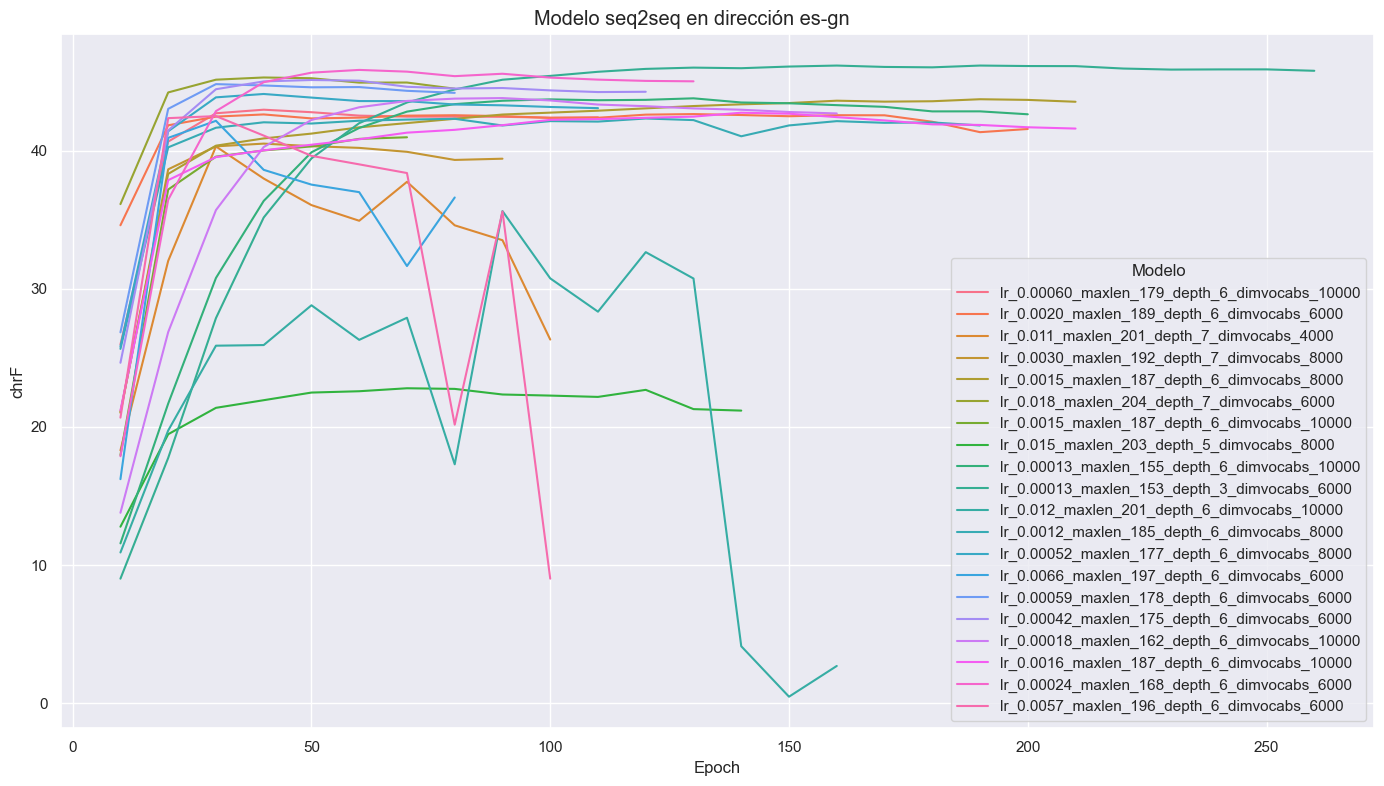

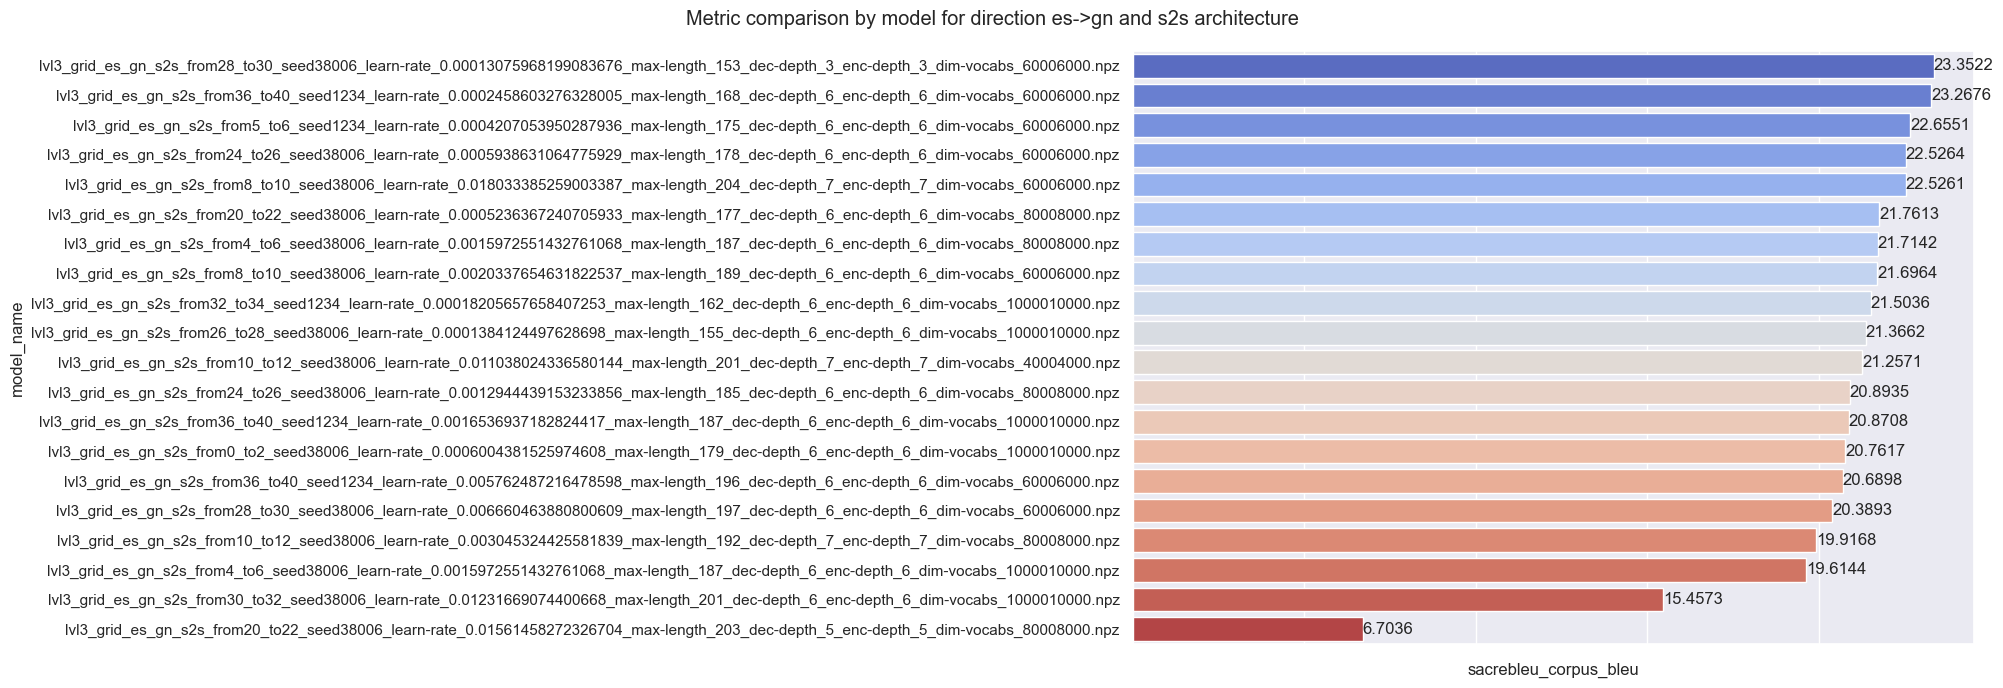

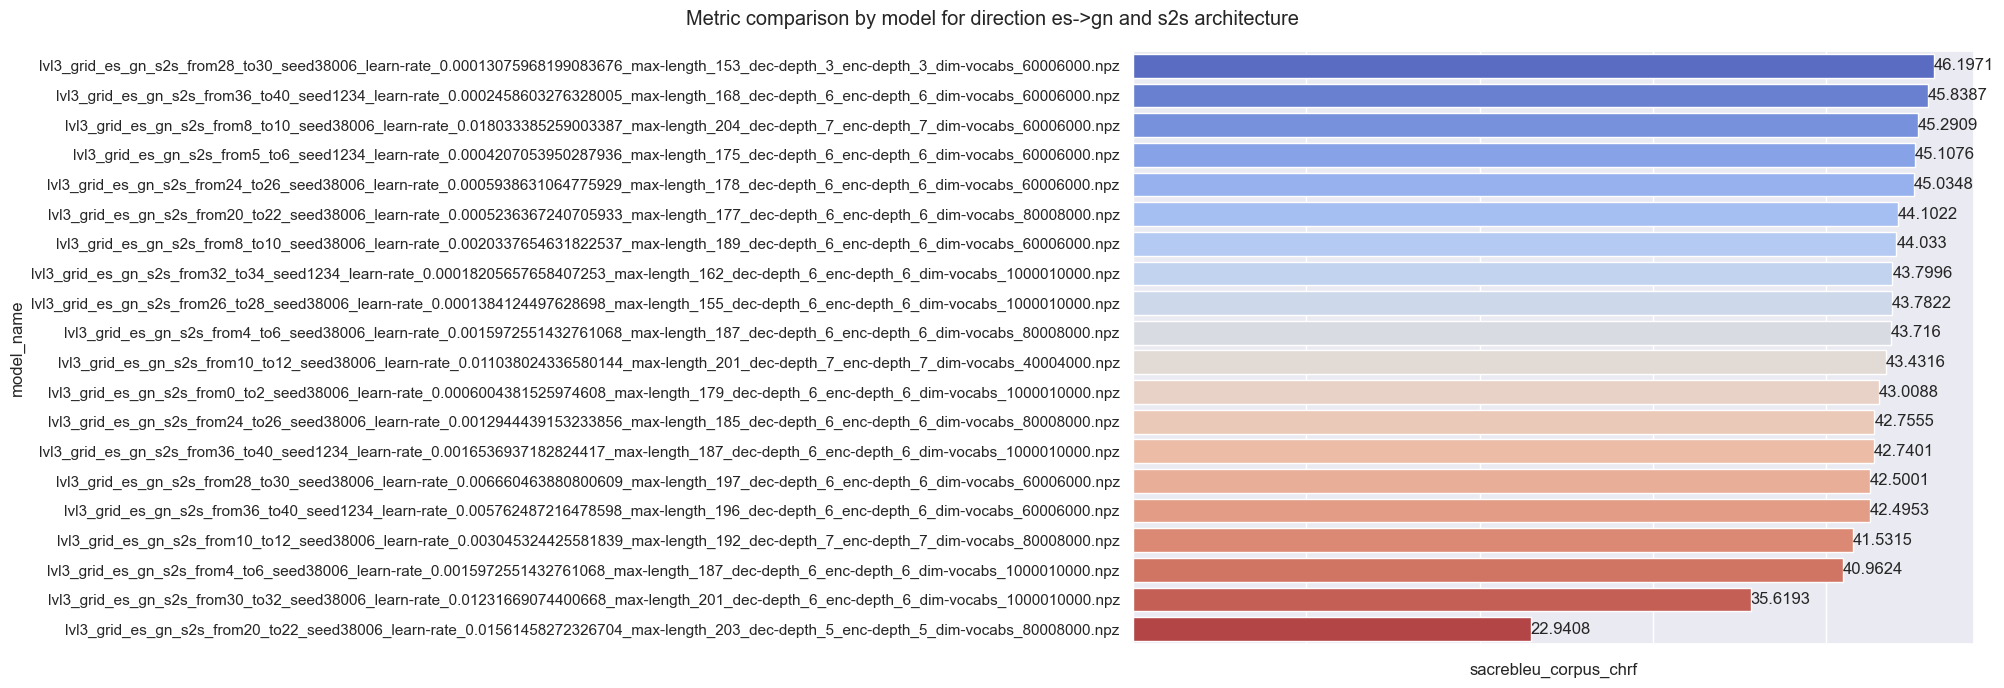

In [353]:
plots.plot_metric_by_epoch_foreach_model(es_gn_lvl3_results_prettier,
                                         metrics=[CHRF_VALUE],
                                            model_name=MODEL_NAME_VALUE,
                                            score_name=SCORE_VALUE,
                                            title='Modelo seq2seq en dirección es-gn',
                                            save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                                   'level3_s2s_es_gn_results.png'),
                                         figsize=(14,8), 
                                         legend=True,
                                         tight_layout=True);
plots.plot_max_score_by_model(es_gn_lvl3_results_df, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7));
plots.plot_max_score_by_model(es_gn_lvl3_results_df, 
                              metrics=['sacrebleu_corpus_chrf'], 
                              figsize=(20,7));

In [354]:
best_model_s2s_es_gn = es_gn_lvl3_results_df.sort_values('score', 
                                                         ascending=False).head(1)
es_gn_lvl3_results_df[es_gn_lvl3_results_df['parameters']==best_model_s2s_es_gn['parameters'].values[0]].head(2)

date  \
566  2023-08-16 11:44:10.613862   
567  2023-08-16 11:44:10.613862   

                                            model_name           source  \
566  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   
567  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   

              target             score_type      score  epoch  \
566  valid_gn.txt.gn  sacrebleu_corpus_chrf  46.197128    190   
567  valid_gn.txt.gn  sacrebleu_corpus_bleu  23.323922    190   

                                            parameters  
566  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
567  {'type': ['s2s'], 'max-length-crop': [], 'drop...

##### **Transformer**

**GN->ES**

In [355]:
lvl3_transformer_gn_es_df = pd.read_csv(LVL3_TRANSFORMER_GN_ES_RESULTS)
lvl3_transformer_gn_es_df = lvl3_transformer_gn_es_df[lvl3_transformer_gn_es_df['score'] >= 0]
lvl3_transformer_gn_es_df.tail()

date  \
2817  2023-08-24 14:27:56.538356   
2818  2023-08-24 14:33:26.991378   
2819  2023-08-24 14:33:26.991378   
2820  2023-08-24 14:38:55.811697   
2821  2023-08-24 14:38:55.811697   

                                             model_name           source  \
2817  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2818  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2819  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2820  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2821  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   

               target             score_type      score  epoch  \
2817  valid_es.txt.es  sacrebleu_corpus_bleu  12.592470    340   
2818  valid_es.txt.es  sacrebleu_corpus_chrf  33.912185    350   
2819  valid_es.txt.es  sacrebleu_corpus_bleu  12.506665    350   
2820  valid_es.txt.es  sacrebleu_corpus_chrf  34.095357    360   
2821  valid_es.txt.es  sacrebleu_corpus_bleu  12.672722    360   

                                             parameters  
2817  {'type': ['transformer'], 'max-length-crop': [...  
2818  {'type': ['transformer'], 'max-length-crop': [...  
2819  {'type': ['transformer'], 'max-length-crop': [...  
2820  {'type': ['transformer'], 'max-length-crop': [...  
2821  {'type': ['transformer'], 'max-length-crop': [...

In [356]:
lvl3_transformer_gn_es_df_prettier = df_prettier(lvl3_transformer_gn_es_df, level=3)

In [357]:
best_transformer_gn_es_models = get_best_scores(lvl3_transformer_gn_es_df_prettier)
best_transformer_gn_es_models.to_csv(os.path.join(FINAL_DOCUMENT_PATH, 'best_transformer_gn_es_models.csv'), index=False)
best_transformer_gn_es_models

Arquitectura Origen Destino learn-rate max-length depth dim-vocabs  Epoch  \
37  transformer     gn      es   3.95e-05        182     3       2000    920   
19  transformer     gn      es   5.50e-05        196     2       2000    990   
29  transformer     gn      es   2.47e-05        166     3       6000    890   
21  transformer     gn      es   8.85e-05        226     3       6000    580   
15  transformer     gn      es   6.50e-05        204     4       4000    640   
27  transformer     gn      es   8.57e-05        223     3       6000    570   
11  transformer     gn      es   3.37e-05        177     2       8000    830   
5   transformer     gn      es   3.40e-05        177     1       2000    920   
7   transformer     gn      es   2.40e-05        165     4       4000    760   
17  transformer     gn      es   9.26e-05        231     2       4000    150   
25  transformer     gn      es    0.00010        255     4      12000    570   
13  transformer     gn      es   2.04e-05        159     3      10000    870   
35  transformer     gn      es   8.85e-05        226     2       8000    230   
9   transformer     gn      es   4.71e-05        189     1       4000    530   
33  transformer     gn      es   3.14e-05        174     1       8000    760   
31  transformer     gn      es   8.15e-05        219     1       6000    370   
23  transformer     gn      es   6.33e-05        203     1       6000    280   
1   transformer     gn      es   9.26e-05        231     1       4000    250   
3   transformer     gn      es   5.91e-05        199     1       6000    370   
39  transformer     gn      es   5.16e-05        193     1       8000    290   

     BLEU   chrF  
37  15.88  39.72  
19  15.75  39.18  
29  15.11  38.15  
21  14.90  37.86  
15  14.84  37.83  
27  14.86  37.78  
11  14.57  37.23  
5   14.12  36.68  
7   14.11  36.67  
17  13.89  36.54  
25  14.30  36.23  
13  14.14  36.07  
35  13.99  36.05  
9   12.97  35.29  
33  13.27  34.94  
31  13.04  34.83  
23  12.77  34.64  
1   12.34  34.62  
3   12.77  34.22  
39  12.62  34.16

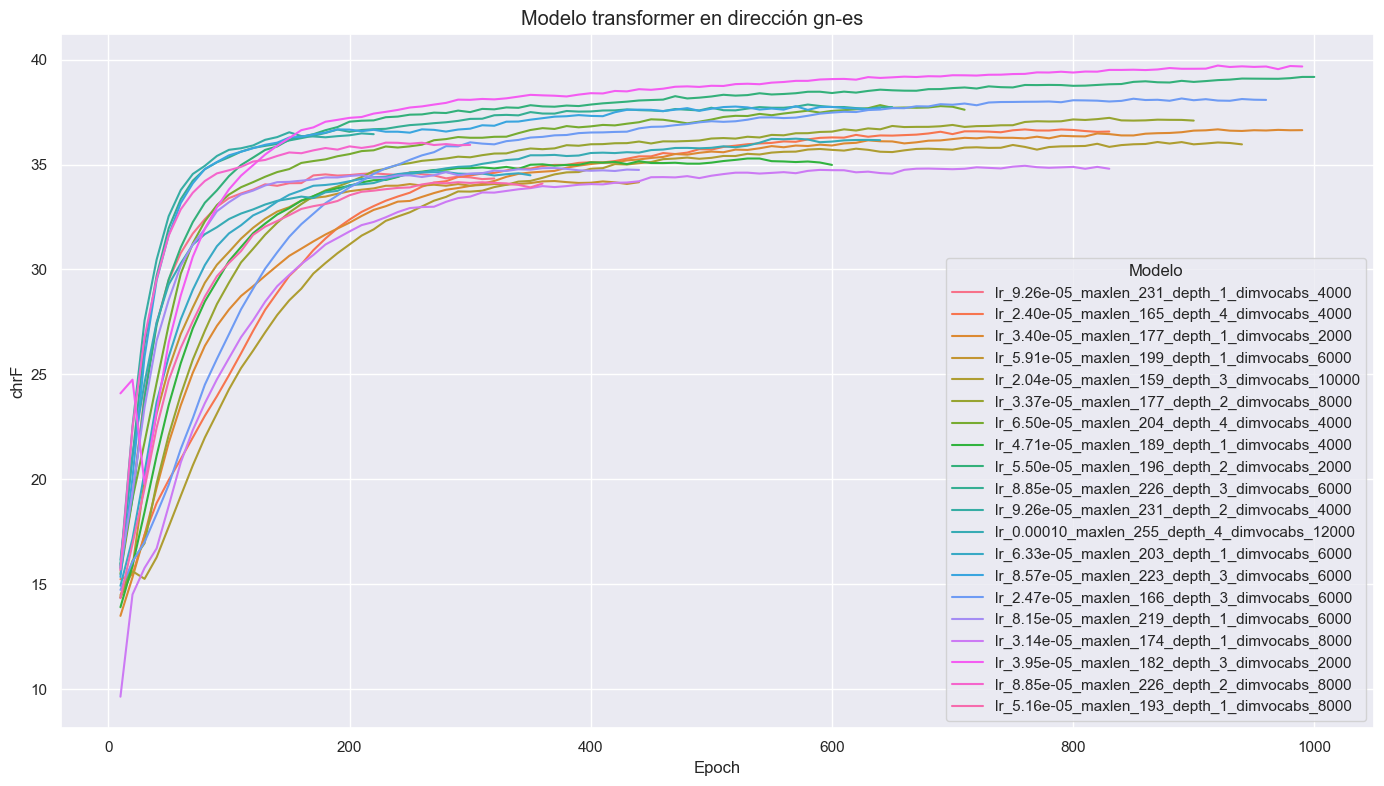

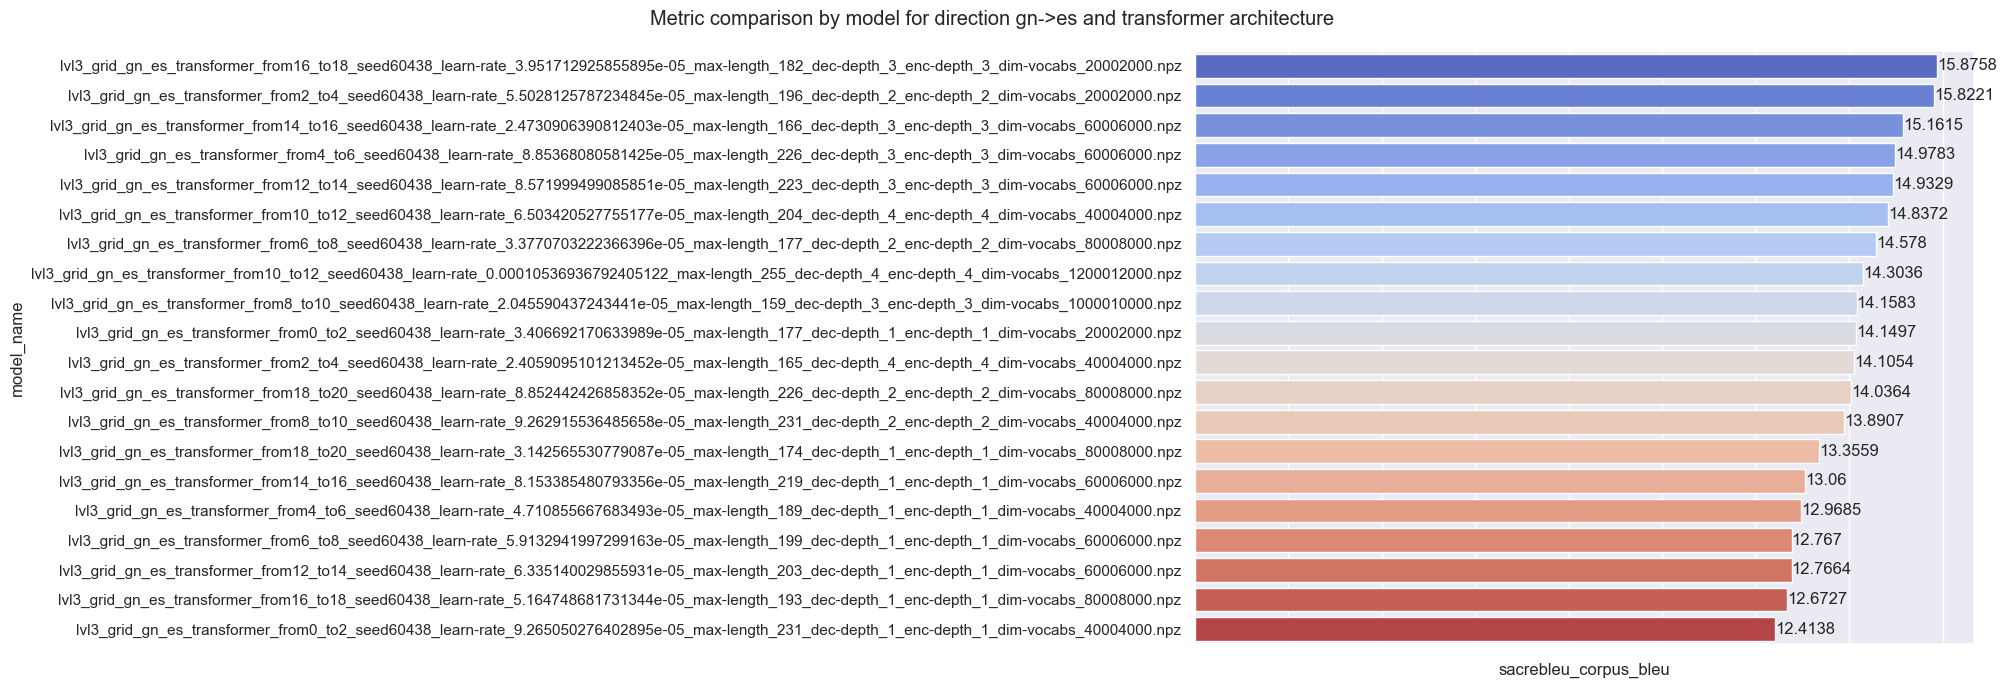

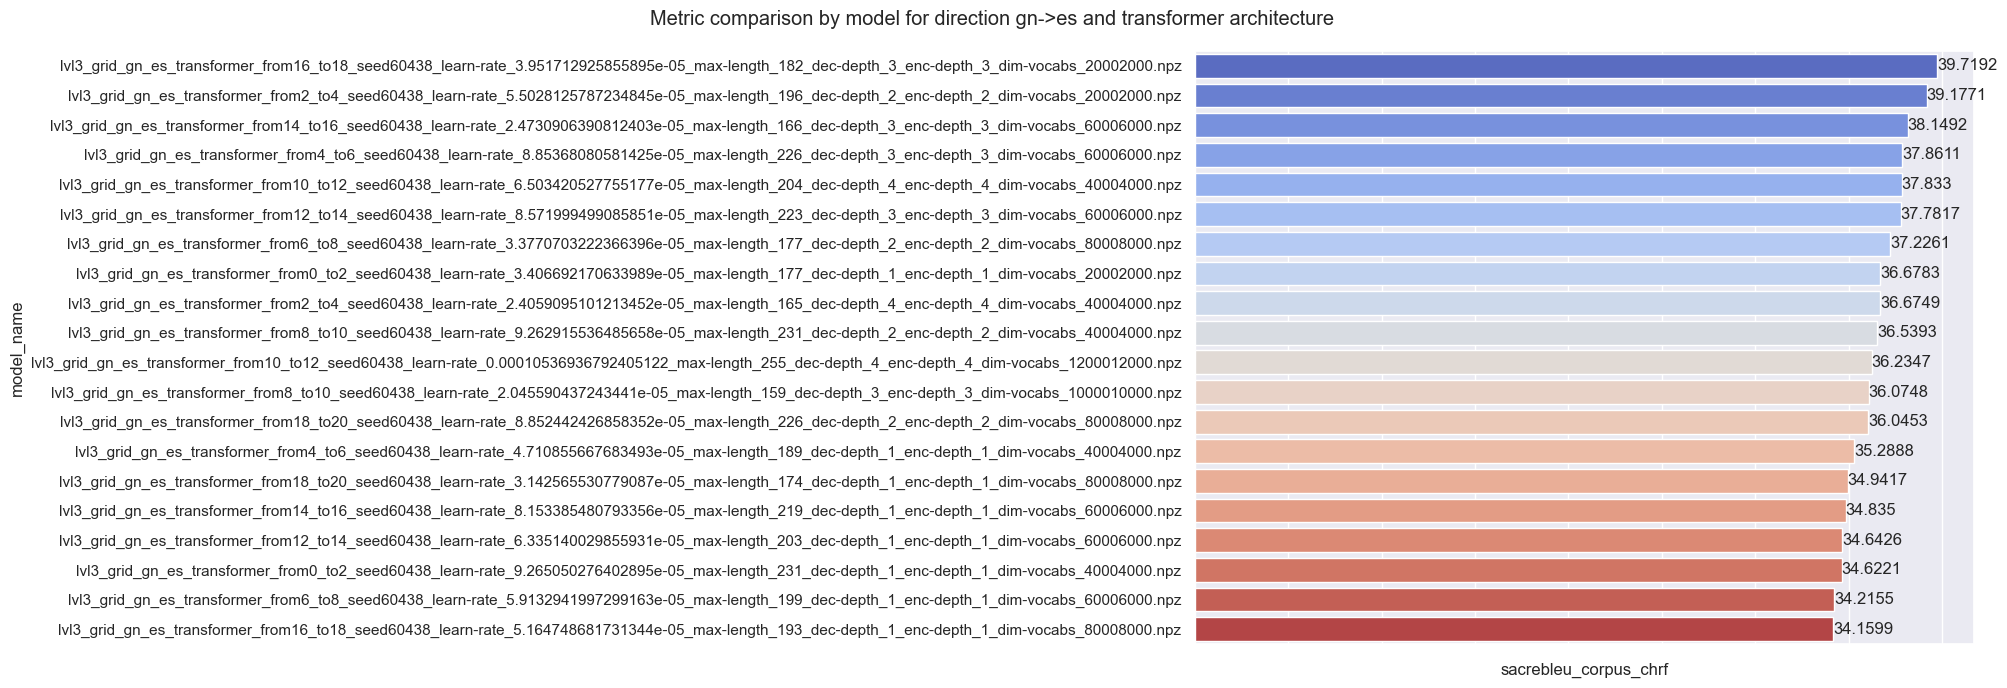

In [358]:
plots.plot_metric_by_epoch_foreach_model(lvl3_transformer_gn_es_df_prettier,
                                         metrics=[CHRF_VALUE],
                                            model_name=MODEL_NAME_VALUE,
                                            score_name=SCORE_VALUE,
                                            title='Modelo transformer en dirección gn-es',
                                            save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                                   'level3_transformer_gn_es_results.png'),
                                         figsize=(14,8), 
                                         legend=True,
                                         tight_layout=True);
plots.plot_max_score_by_model(lvl3_transformer_gn_es_df, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7));
plots.plot_max_score_by_model(lvl3_transformer_gn_es_df, 
                              metrics=['sacrebleu_corpus_chrf'], 
                              figsize=(20,7));

In [359]:
best_model_transformer_gn_es = lvl3_transformer_gn_es_df.sort_values('score', ascending=False).head(1)
lvl3_transformer_gn_es_df[lvl3_transformer_gn_es_df['parameters']==best_model_transformer_gn_es['parameters'].values[0]].head(2)

date  \
2734  2023-08-24 10:03:52.144057   
2735  2023-08-24 10:03:52.144057   

                                             model_name           source  \
2734  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2735  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   

               target             score_type      score  epoch  \
2734  valid_es.txt.es  sacrebleu_corpus_chrf  39.719175    920   
2735  valid_es.txt.es  sacrebleu_corpus_bleu  15.875761    920   

                                             parameters  
2734  {'type': ['transformer'], 'max-length-crop': [...  
2735  {'type': ['transformer'], 'max-length-crop': [...

**Transformer**

**ES->GN**

In [360]:
lvl3_transformer_es_gn_df = pd.read_csv(LVL3_TRANSFORMER_ES_GN_RESULTS)
lvl3_transformer_es_gn_df = lvl3_transformer_es_gn_df[lvl3_transformer_es_gn_df['score'] > 0]
lvl3_transformer_es_gn_df.head()

date  \
0  2023-08-20 14:30:57.399870   
1  2023-08-20 14:30:57.399870   
2  2023-08-20 14:38:02.769007   
3  2023-08-20 14:38:02.769007   
4  2023-08-20 14:44:47.938906   

                                          model_name           source  \
0  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
1  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
2  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
3  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
4  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   

            target             score_type     score  epoch  \
0  valid_gn.txt.gn  sacrebleu_corpus_chrf  4.066554     10   
1  valid_gn.txt.gn  sacrebleu_corpus_bleu  0.039525     10   
2  valid_gn.txt.gn  sacrebleu_corpus_chrf  6.737243     20   
3  valid_gn.txt.gn  sacrebleu_corpus_bleu  1.072929     20   
4  valid_gn.txt.gn  sacrebleu_corpus_chrf  7.799798     30   

                                          parameters  
0  {'quiet-translation': [], 'overwrite': [], 'ea...  
1  {'quiet-translation': [], 'overwrite': [], 'ea...  
2  {'quiet-translation': [], 'overwrite': [], 'ea...  
3  {'quiet-translation': [], 'overwrite': [], 'ea...  
4  {'quiet-translation': [], 'overwrite': [], 'ea...

In [361]:
lvl3_transformer_es_gn_df_prettier = df_prettier(lvl3_transformer_es_gn_df, level=3)

In [362]:
best_transformer_es_gn_models = get_best_scores(lvl3_transformer_es_gn_df_prettier)
best_transformer_es_gn_models.to_csv(os.path.join(FINAL_DOCUMENT_PATH, 'best_transformer_es_gn_models.csv'), index=False)
best_transformer_es_gn_models

Arquitectura Origen Destino learn-rate max-length depth dim-vocabs  Epoch  \
31  transformer     es      gn   5.77e-05        198     2       2000    800   
43  transformer     es      gn   5.79e-05        198     3       4000    950   
35  transformer     es      gn   3.93e-05        182     4       2000    630   
79  transformer     es      gn   9.98e-05        242     3       6000    780   
25  transformer     es      gn   9.22e-05        230     4       4000    570   
63  transformer     es      gn   2.18e-05        161     5       2000    730   
47  transformer     es      gn    0.00010        268     4       6000    820   
51  transformer     es      gn   7.55e-05        213     3      10000    960   
19  transformer     es      gn   7.22e-05        210     4       6000    850   
71  transformer     es      gn   7.77e-05        215     4      10000    980   
67  transformer     es      gn   4.52e-05        188     1       4000    980   
75  transformer     es      gn   5.58e-05        197     5       6000   1000   
55  transformer     es      gn   3.70e-05        180     1       6000    960   
39  transformer     es      gn   4.86e-05        190     1       6000    900   
7   transformer     es      gn   5.17e-05        193     1       6000    810   
1   transformer     es      gn    0.00010        245     1       4000    260   
73  transformer     es      gn   1.67e-05        151     4       8000    870   
59  transformer     es      gn   9.33e-05        232     5       6000   1000   
13  transformer     es      gn   5.70e-05        198     4       8000    220   
77  transformer     es      gn   3.72e-05        180     5      10000   1000   

     BLEU   chrF  
31  15.73  40.35  
43  13.84  38.32  
35  13.55  38.27  
79  13.77  37.49  
25  12.44  35.86  
63  11.95  35.81  
47  12.47  35.74  
51  12.53  35.72  
19  12.33  35.70  
71  12.16  34.75  
67  11.15  33.39  
75  11.43  33.26  
55  10.86  32.60  
39  10.88  32.58  
7   10.96  32.56  
1   10.56  32.32  
73  10.74  32.10  
59  10.64  31.66  
13  10.39  31.29  
77   9.89  29.96

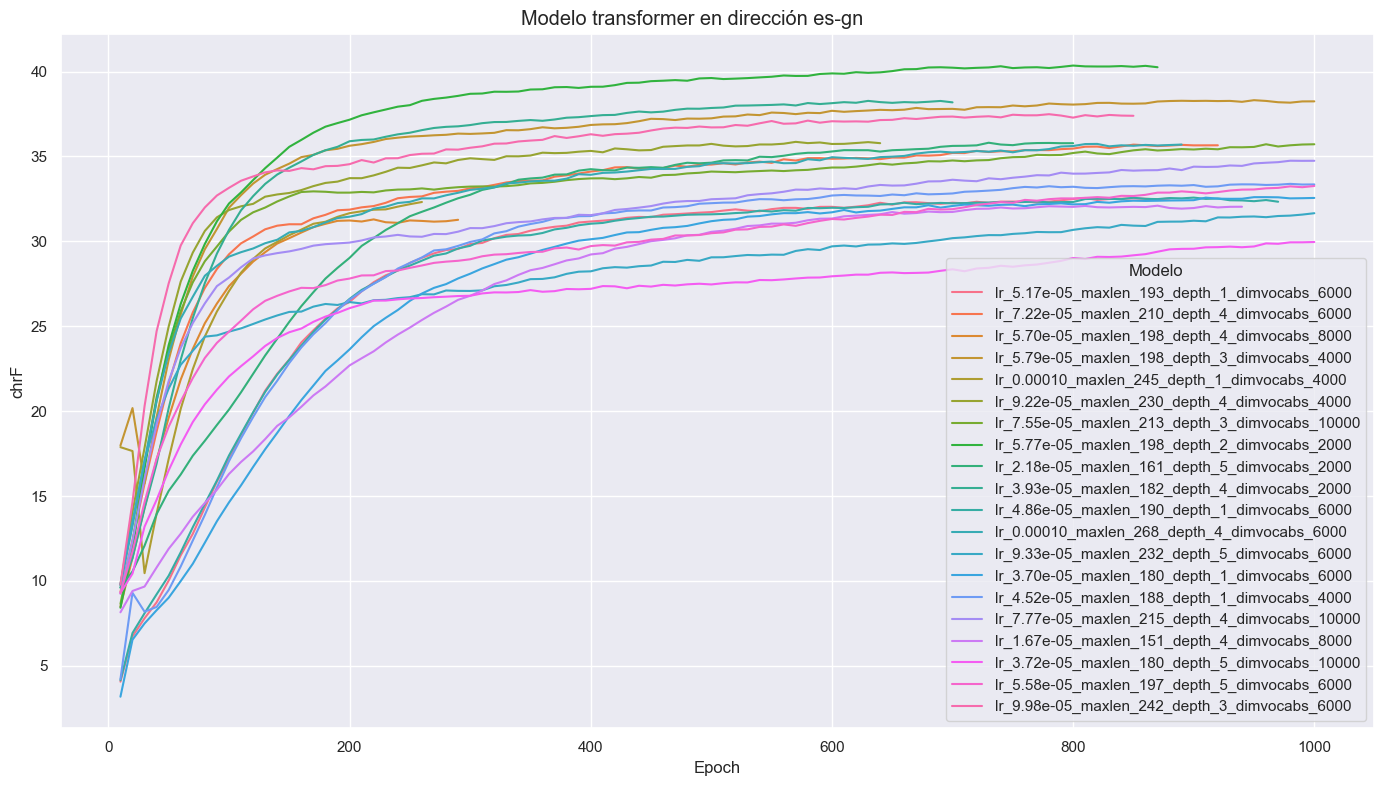

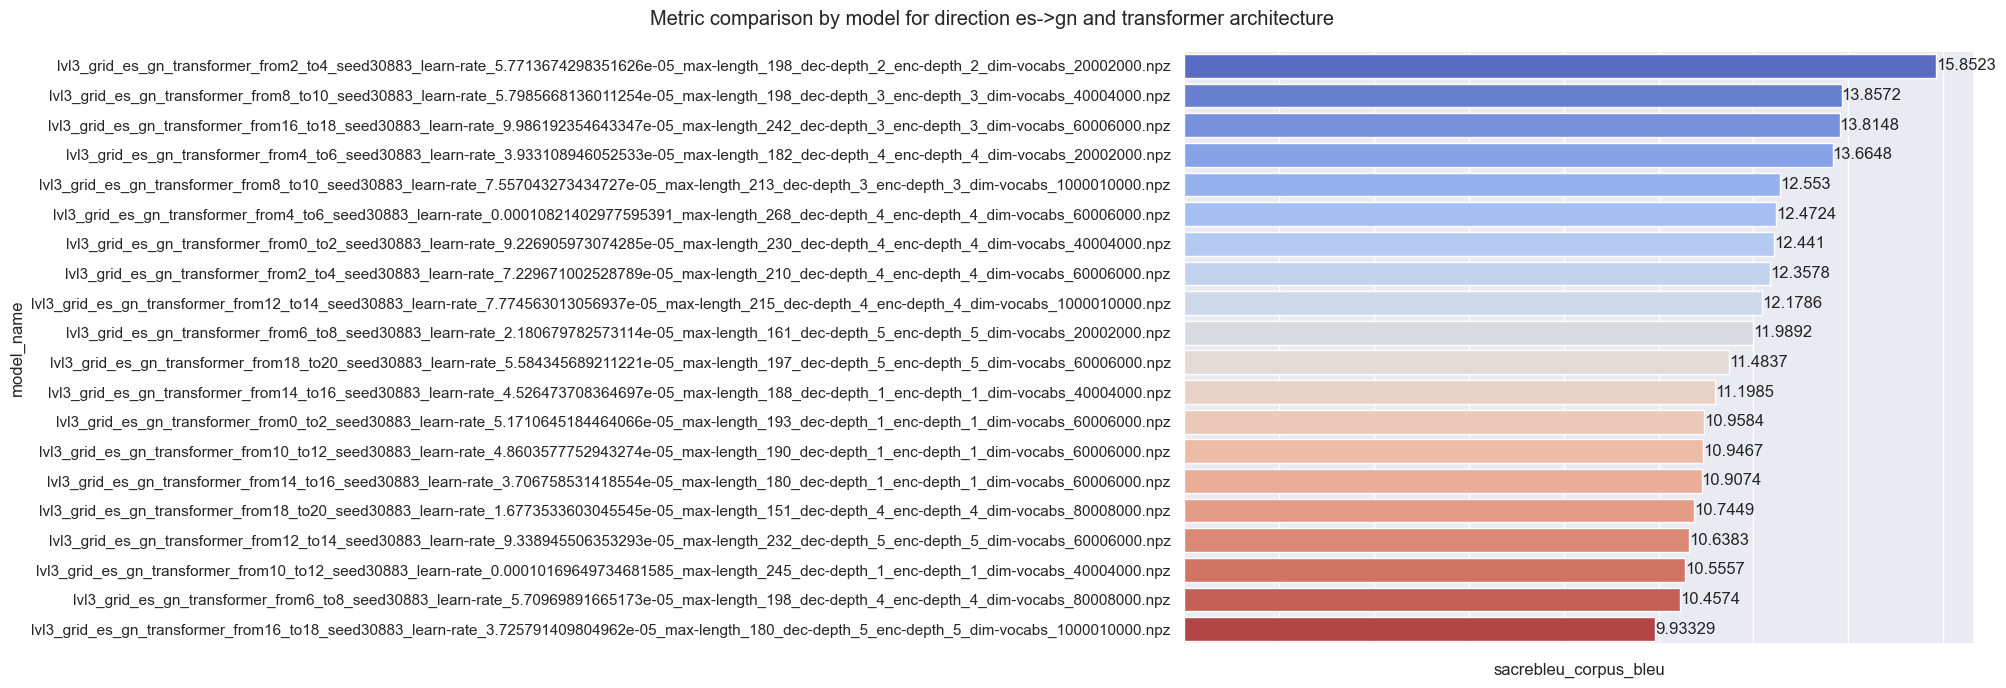

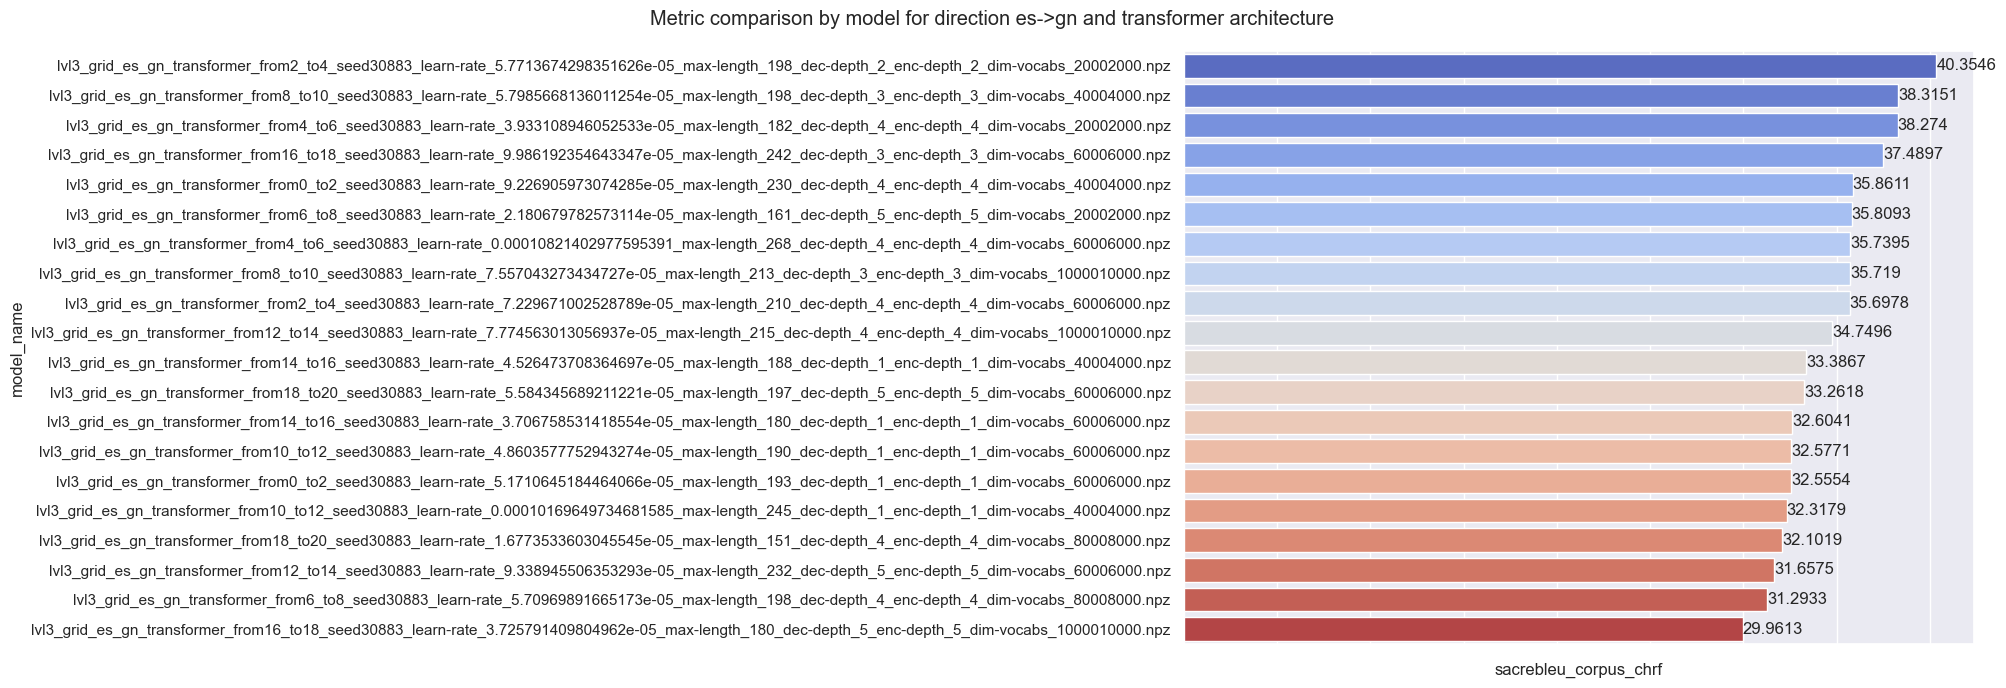

In [363]:
plots.plot_metric_by_epoch_foreach_model(lvl3_transformer_es_gn_df_prettier,
                                         metrics=[CHRF_VALUE],
                                            model_name=MODEL_NAME_VALUE,
                                            score_name=SCORE_VALUE,
                                            title='Modelo transformer en dirección es-gn',
                                            save_path=os.path.join(FINAL_DOCUMENT_PATH, 
                                                                   'level3_transformer_es_gn_results.png'),
                                         figsize=(14,8), 
                                         legend=True,
                                         tight_layout=True);
plots.plot_max_score_by_model(lvl3_transformer_es_gn_df, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7));
plots.plot_max_score_by_model(lvl3_transformer_es_gn_df, 
                              metrics=['sacrebleu_corpus_chrf'], 
                              figsize=(20,7));

In [364]:
best_model_transformer_es_gn = lvl3_transformer_es_gn_df.sort_values('score', ascending=False).head(1)
lvl3_transformer_es_gn_df[lvl3_transformer_es_gn_df['parameters']==best_model_transformer_es_gn['parameters'].values[0]].head(2)

date  \
1948  2023-08-21 20:57:50.276785   
1949  2023-08-21 20:57:50.276785   

                                             model_name           source  \
1948  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   
1949  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   

               target             score_type      score  epoch  \
1948  valid_gn.txt.gn  sacrebleu_corpus_chrf  40.354648    800   
1949  valid_gn.txt.gn  sacrebleu_corpus_bleu  15.734143    800   

                                             parameters  
1948  {'quiet-translation': [], 'overwrite': [], 'ea...  
1949  {'quiet-translation': [], 'overwrite': [], 'ea...

### **LVL3 Summary**

In [365]:
lvl3_results = [best_model_s2s_gn_es,
                best_model_s2s_es_gn,
                best_model_transformer_gn_es,
                best_model_transformer_es_gn]

In [366]:
def create_lvl3_summary(lvl3_results: list[pd.DataFrame]):
    summary_df = {"model_name": [], 
                  "source_language": [], 
                  "target_language": [], 
                  "score_type": [], 
                  "score": []}
    
    for df in lvl3_results:
        for _, row in df.iterrows():
            summary_df['model_name'].append(row['model_name'])
            summary_df['source_language'].append(row['source'])
            summary_df['target_language'].append(row['target'])
            summary_df['score_type'].append(row['score_type'])
            summary_df['score'].append(row['score'])

    return pd.DataFrame(summary_df)

In [367]:
summary_df = create_lvl3_summary(lvl3_results)
summary_df

model_name  source_language  \
0  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   
1  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   
2  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
3  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   

   target_language             score_type      score  
0  valid_es.txt.es  sacrebleu_corpus_chrf  47.319293  
1  valid_gn.txt.gn  sacrebleu_corpus_chrf  46.197128  
2  valid_es.txt.es  sacrebleu_corpus_chrf  39.719175  
3  valid_gn.txt.gn  sacrebleu_corpus_chrf  40.354648

In [368]:
def extract_hyperparameters(df: pd.DataFrame, 
                            features: list, 
                            from_='model_name'):
    features_df = {feature: [] for feature in features}
    for feature in features:
        sep = '_' if feature != 'seed' else ''
        regex = f'{feature}{sep}([^_]+)'
        extracted_features = df[from_].str.extract(regex)[0].tolist()
        features_df[feature].extend(extracted_features)

    return pd.DataFrame(features_df)

In [369]:
features = ["seed", 
            "learn-rate", 
            "max-length", 
            "dec-depth", 
            "enc-depth", 
            "dim-vocabs"]
hyperparameter_df = extract_hyperparameters(summary_df, features)
pd.concat([summary_df, hyperparameter_df], axis=1)

model_name  source_language  \
0  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   
1  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   
2  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
3  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   

   target_language             score_type      score   seed  \
0  valid_es.txt.es  sacrebleu_corpus_chrf  47.319293   1234   
1  valid_gn.txt.gn  sacrebleu_corpus_chrf  46.197128  38006   
2  valid_es.txt.es  sacrebleu_corpus_chrf  39.719175  60438   
3  valid_gn.txt.gn  sacrebleu_corpus_chrf  40.354648  30883   

               learn-rate max-length dec-depth enc-depth    dim-vocabs  
0   0.0016480446427978965        187         6         6  60006000.npz  
1  0.00013075968199083676        153         3         3  60006000.npz  
2   3.951712925855895e-05        182         3         3  20002000.npz  
3  5.7713674298351626e-05        198         2         2  20002000.npz

In [370]:
all_dfs = [lvl3_transformer_es_gn_df, 
           lvl3_transformer_gn_es_df, 
           gn_es_lvl3_results_df, 
           es_gn_lvl3_results_df]

best_models_df = [df[df['model_name'].isin(summary_df['model_name'])] \
                  for df in all_dfs]
best_models_df = pd.concat(best_models_df, axis=0)
best_models_df.to_csv(BEST_MODELS_CSV)

**LVL3 RESULTS**

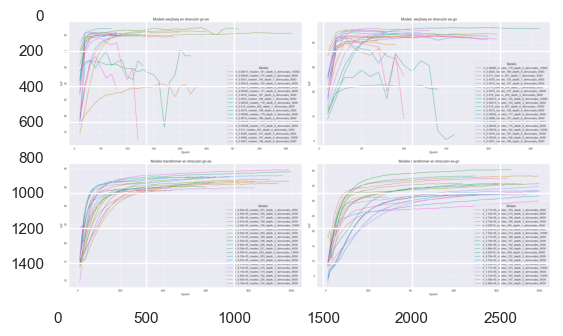

In [371]:
lvl3_images = [
    "level3_s2s_gn_es_results.png",
    "level3_s2s_es_gn_results.png",
    "level3_transformer_gn_es_results.png",
    "level3_transformer_es_gn_results.png"
]

from PIL import Image
import matplotlib.pyplot as plt

images = [Image.open(os.path.join(FINAL_DOCUMENT_PATH, image)) \
            for image in lvl3_images]

widths, heights = zip(*(i.size for i in images))

total_width = max(sum(widths[:2]), sum(widths[2:]))
max_height = max(heights[:2]) + max(heights[2:])

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images[:2]:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
    
x_offset = 0
for im in images[2:]:
    new_im.paste(im, (x_offset,max_height//2))
    x_offset += im.size[0]

new_im.save(os.path.join(FINAL_DOCUMENT_PATH, 'level3_results.png'))
plt.imshow(new_im);